# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [87]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

churn_data_frame = pd.read_csv("..\..\Data\orange_small_churn_data.train", ",")
churn_labels_frame = pd.read_csv("..\..\Data\orange_small_churn_labels.train", header=None)
churn_data_frame.shape

(40000, 230)

In [88]:
churn_labels_frame.shape

(40000, 1)

2\. Рассчитайте доли классов `отток` и `не отток`.

In [3]:
def show_proportion_data(frame):
    proportion_plot = frame.plot(
        kind="hist",
        title="Labels proportion",
        figsize=(2,3),
        legend=False)
    proportion_plot.set_xlabel("Label value")
    proportion_plot.set_ylabel("Label frequency")
    not_churn_proportion = float(frame[frame[0] == -1].shape[0])/float(frame.shape[0])
    churn_proportion = float(frame[frame[0] == 1].shape[0])/float(frame.shape[0])
    print ("Доля ответов класса \"отток\": %.4f%%\nДоля ответов класса \"не отток\": %.4f%%\nКласса \"отток\" меньше в %.4f раз" % (churn_proportion, not_churn_proportion, not_churn_proportion/churn_proportion))

Доля ответов класса "отток": 0.0744%
Доля ответов класса "не отток": 0.9256%
Класса "отток" меньше в 12.4409 раз


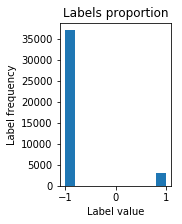

In [4]:
show_proportion_data(churn_labels_frame)

**По долям ответов класса "отток" и "не отток" видно, что выборка сильно перекошена и наблюдений класса "отток" существенно меньше.**

**Повторим данные класса "отток" 11 раз, чтобы сбалансировать выборку.**

**Это упростит сравнение данных на графиках и не должно повлиять на результат, т.к. в этом задании мы работаем с аггрегированными данными.**

Доля ответов класса "отток": 0.4910%
Доля ответов класса "не отток": 0.5090%
Класса "отток" меньше в 1.0367 раз


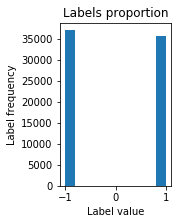

In [5]:
churn_only_labels = churn_labels_frame[churn_labels_frame[0] == 1]
churn_indices = list(churn_only_labels.index)
churn_only_frame = churn_data_frame.loc[churn_indices,:]
churn_balanced_frame = churn_data_frame.copy()
churn_balanced_labels = churn_labels_frame.copy()
for i in range(0, 11):
    churn_balanced_frame = pd.concat([churn_balanced_frame, churn_only_frame], ignore_index=True)
    churn_balanced_labels = pd.concat([churn_balanced_labels, churn_only_labels], ignore_index=True)
show_proportion_data(churn_balanced_labels)

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles

**Поскольку признаки и целевая функция имеют разные типы (численный или категориальный для признаков и бинарный для ответов). Поэтому корреляции Пирсона и Спирмена применять нельзя. Можно посчитать меру силы взаимосвязи по формуле**
$$E(X1 |X2 = 1)−E(X1 |X2 = -1)$$
**Матожидание в выборке приблизим средним, тогда получим**
$$\frac{\sum_{i=1}^n{{(x_{i}|y_{i}=1)}}}{k} - \frac{\sum_{i=1}^n{{(x_{i}|y_{i}=-1)}}}{\ell}$$
где $k$ - количество наблюдений с $y=1$, а $\ell$ - количество наблюдений с $y=-1$

**Можно взять от полученных значений модуль, т.к. большое отрицательное значение будет характеризовать обратную взаимосвязь и отсортировать значения по убыванию**

In [6]:
def scale_frame(frame):
    """Функция масштабирает frame на отрезок [0;1]"""
    scaler = StandardScaler()
    scaled_matrix = scaler.fit_transform(frame.as_matrix())
    return pd.DataFrame(scaled_matrix, columns=frame.columns)

def split_frame(frame, n_columns, c_columns):
    """Функция разбивает фрейм на два числовой и категориальный, а также масштабирует значения и заполняет пропуски."""
    n_frame = frame[n_columns].copy()
    c_frame = frame[c_columns].copy()
    # Посчитаем средние по колонкам
    numeric_means = n_frame.mean(axis=0, skipna=True)
    # Оставим только те колонки, в которых среднее значение не равно NaN, т.к. в таких колонках совсем нет значений
    numeric_means = numeric_means.dropna()
    dropped_numeric_colums = n_frame.columns.drop(numeric_means.index)
    n_frame = n_frame[list(numeric_means.index)]
    # Заполним пропущенные численные значения средними
    n_frame = n_frame.fillna(numeric_means, axis=0)
    # Заполним пропущенные категориальные значения строками "NaV" (Not a value)
    c_frame = c_frame.fillna("NaV")
    # Посчитаем количества уникальных значений по колонкам
    cat_unique_counts = c_frame.nunique()
    num_unique_counts = n_frame.nunique()
    # Удалим колонки с одним уникальным значением
    cat_columns_to_drop = cat_unique_counts[cat_unique_counts == 1].index
    num_columns_to_drop = num_unique_counts[num_unique_counts == 1].index
    c_frame = c_frame.drop(columns=cat_columns_to_drop)
    n_frame = n_frame.drop(columns=num_columns_to_drop)
    
    dropped_columns = np.concatenate([
        dropped_numeric_colums,
        list(num_columns_to_drop),
        list(cat_columns_to_drop)])
    # В конце масштабируем числовой frame на отрезок [0;1]
    return (scale_frame(n_frame), c_frame, dropped_columns)

def calculate_interrelations(frame, labels, first_class, second_class):
    # Выделим индексы отток/не отток
    first_indices = list(labels[labels[0] == first_class].index)
    second_indices = list(labels[labels[0] == second_class].index)
    # Средние значения в матрице значений "отток" по колонкам
    first_class_means = frame.loc[first_indices,:].mean(axis=0)
    # Средние значения в матрице значений "не отток" по колонкам
    second_class_means = frame.loc[second_indices,:].mean(axis=0)
    # Меры взаимосвязи
    interrelations = (first_class_means-second_class_means).abs().sort_values(ascending=False)
    return (interrelations,first_indices,second_indices)

def build_pivot_table(frame, labels, column):
    """ Функция строит таблицу сопряженности по колонке фрейма и фрейму целевой переменной """
    combined_frame = pd.concat([frame[column], frame[column], labels], axis=1)
    combined_frame.columns = [column, "values", "labels"]
    frame_pivot = pd.pivot_table(
        combined_frame,
        values=["values"],
        index=[column],
        columns=["labels"],
        fill_value = 0,
        aggfunc="count")
    return frame_pivot.as_matrix()

def v_Cramer_correlation(pivot_table):
    """ Функция считает корреляцию Крамера по таблице сопряженности """
    chi_stat = stats.chi2_contingency(pivot_table)[0]
    k_min = np.min(pivot_table.shape)
    n = np.sum(pivot_table)
    return np.sqrt(chi_stat/(n*(k_min-1)))

def v_Cramer_correlations(frame, labels):
    """ Функция считает корреляции Крамера по всем колонкам фрейма """
    correlations = []
    for col in frame.columns:
        pivot = build_pivot_table(frame, labels, col)
        correlations.append((col, v_Cramer_correlation(pivot)))
    return sorted(correlations, key=lambda v: v[1], reverse=True)

In [7]:
# Выделим отдельно числовые и категориальные колонки.
numeric_columns = churn_balanced_frame.columns[:190]
categorial_columns = churn_balanced_frame.columns[190:]

numeric_frame, categorial_frame, dropped_columns = split_frame(
    churn_data_frame,
    numeric_columns,
    categorial_columns)
numeric_balanced_frame, categorial_balanced_frame, dropped_bal_columns = split_frame(
    churn_balanced_frame,
    numeric_columns,
    categorial_columns)

# Меры взаимосвязи
balanced_interrelations, churn_balanced_indices, not_churn_balanced_indices = calculate_interrelations(
    numeric_balanced_frame,
    churn_balanced_labels,
    1,
    -1)
interrelations, churn_indices, not_churn_indices = calculate_interrelations(
    numeric_frame,
    churn_labels_frame,
    1,
    -1)
print("Удаленные колонки без значений: \"%s\"" % ("\", \"".join(dropped_bal_columns)))

Удаленные колонки без значений: "Var8", "Var15", "Var20", "Var31", "Var32", "Var39", "Var42", "Var48", "Var52", "Var55", "Var79", "Var141", "Var167", "Var169", "Var175", "Var185", "Var118", "Var209", "Var230"


In [8]:
# Посчитаем корреляции крамера
Cramer_correlations = pd.DataFrame(
    v_Cramer_correlations(categorial_balanced_frame, churn_balanced_labels),
    columns=["Feature", "Correlation"])
Cramer_correlations

Feature  Correlation
0   Var217     0.718600
1   Var200     0.632935
2   Var214     0.632935
3   Var202     0.603258
4   Var199     0.490521
5   Var198     0.449244
6   Var220     0.449244
7   Var222     0.449244
8   Var216     0.352469
9   Var192     0.218485
10  Var212     0.177466
11  Var206     0.170348
12  Var228     0.156331
13  Var197     0.153543
14  Var193     0.146816
15  Var218     0.146063
16  Var204     0.133679
17  Var229     0.121415
18  Var205     0.121169
19  Var207     0.119117
20  Var227     0.113427
21  Var225     0.110495
22  Var221     0.101073
23  Var226     0.092216
24  Var210     0.078465
25  Var195     0.066329
26  Var211     0.063661
27  Var219     0.055439
28  Var194     0.038808
29  Var201     0.034744
30  Var213     0.033917
31  Var191     0.029279
32  Var203     0.027732
33  Var223     0.024545
34  Var208     0.023328
35  Var196     0.021428
36  Var224     0.018365
37  Var215     0.010899

In [9]:
# Обратим внимание, что в ячейках, для которых значение корреляции Крамера получилось "nan" всего одно значение, значит их можно
# безболезненно выбросить из модели
Cramer_correlations = Cramer_correlations.dropna()
categorial_features = Cramer_correlations["Feature"].as_matrix()
categorial_balanced_frame = categorial_balanced_frame[categorial_features]
categorial_frame = categorial_frame[categorial_features]

4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

In [10]:
# Выделим топ 20 числовых признаков наиболее сильно коррелирующих с целевой переменной
# для сбалансированной и несбалансированной выборки.
top_balanced_columns = balanced_interrelations.head(20).index
top_columns = interrelations.head(20).index
# Выделим топ 10 числовых признаков наименее сильно коррелирующих с целевой переменной
# для сбалансированной и несбалансированной выборки.
bottom_balanced_columns = balanced_interrelations.tail(10).index
bottom_columns = interrelations.tail(10).index
class_descriptions = [(0, not_churn_balanced_indices, "not churn", "blue"), (1, churn_balanced_indices, "churn", "red")]

In [11]:
# Сравним получившиеся списки, чтобы убедиться, что после балансировки данные существенно не изменились.
print("Наиболее сильно коррелирующие признаки:")
print(pd.DataFrame({"original": list(top_columns), "balanced": list(top_balanced_columns)}))
print("Наименее сильно коррелирующие признаки:")
print(pd.DataFrame({"original": list(bottom_columns), "balanced": list(bottom_balanced_columns)}))

Наиболее сильно коррелирующие признаки:
   balanced original
0    Var189   Var189
1     Var73    Var73
2      Var7     Var7
3    Var113   Var113
4     Var13   Var144
5    Var144    Var13
6    Var126   Var126
7     Var65    Var65
8     Var74    Var81
9     Var72    Var74
10    Var81    Var72
11   Var140   Var140
12     Var6     Var6
13   Var125   Var168
14   Var188    Var28
15   Var168   Var125
16    Var28   Var160
17   Var160   Var188
18   Var119   Var119
19    Var94   Var149
Наименее сильно коррелирующие признаки:
  balanced original
0    Var58    Var58
1     Var4     Var4
2   Var121   Var121
3    Var16    Var16
4    Var64    Var64
5   Var146   Var146
6   Var123   Var123
7   Var104   Var105
8   Var105   Var104
9   Var129   Var129


In [11]:
def build_scatter_plots(frame, features, class_descriptions):
    """ Функция строит диаграммы рассеяния выбранных колонок датасета и подсвечивает классы цветами """
    for feature_idx, first_feature in enumerate(features):
        for second_feature_idx, second_feature in list(enumerate(features))[feature_idx+1:]:
            fig, axes = plt.subplots(
                nrows=1,
                ncols=3,
                sharey=True,
                figsize=(10, 4))
            for col_idx, indices, data_class, color in class_descriptions:
                axes[0].set(ylabel=second_feature)
                axes[1].set(xlabel=first_feature)
                axes[0].scatter(
                    frame.loc[indices,first_feature].as_matrix().flatten(),
                    frame.loc[indices,second_feature].as_matrix().flatten(),
                    color=color,
                    alpha=0.3)
                axes[col_idx+1].scatter(
                    frame.loc[indices,first_feature].as_matrix().flatten(),
                    frame.loc[indices,second_feature].as_matrix().flatten(),
                    color=color)
            plt.show()

In [12]:
def build_distribution_plots(frame, features, class_descriptions):
    """ Функция строит гистограммы распределений выбранных колонок датасета по классам """
    fig, axes = plt.subplots(
        nrows=int(len(features)/2 + 1),
        ncols=2,
        figsize=(10, 25))
    for feature_idx, col in enumerate(features):
        data = []
        colors = []
        labels = []
        for cl_idx, indices, data_class, color in class_descriptions:
            data.append(frame.loc[indices,col].as_matrix().flatten())
            colors.append(color)
            labels.append(data_class)
        ax = axes[int(feature_idx/2)][feature_idx%2]
        ax.hist(
            data,
            histtype='bar',
            color=colors,
            label=labels)
        ax.legend()
        ax.set_title(col)
    plt.show()

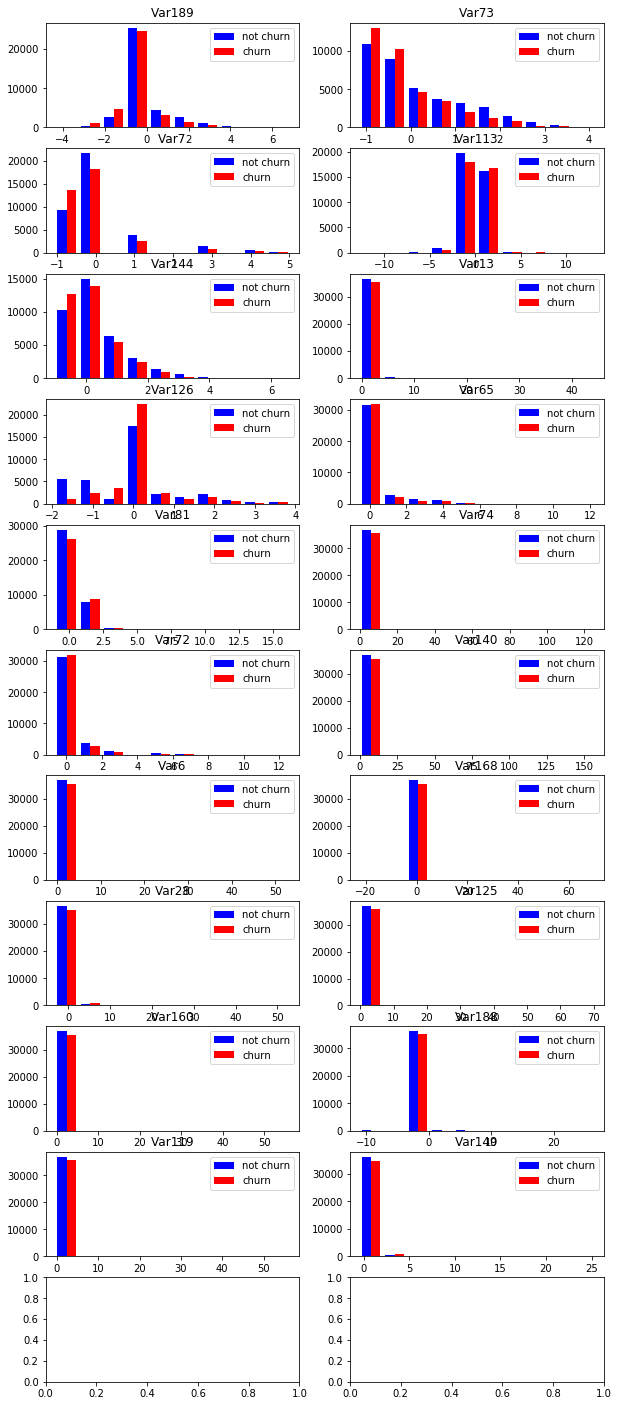

In [14]:
build_distribution_plots(numeric_balanced_frame, top_columns, class_descriptions)

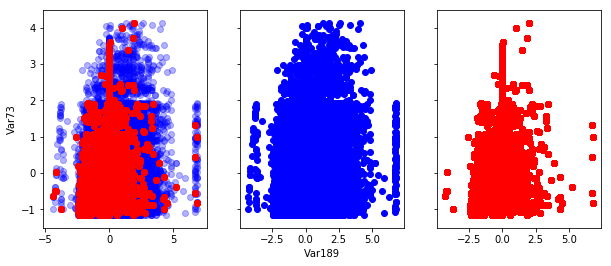

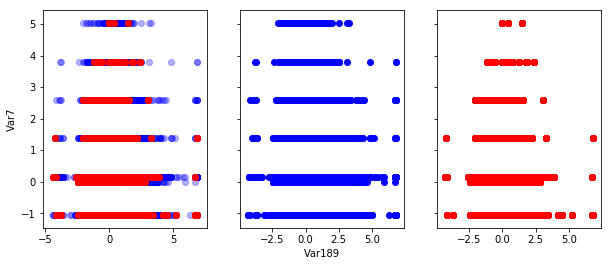

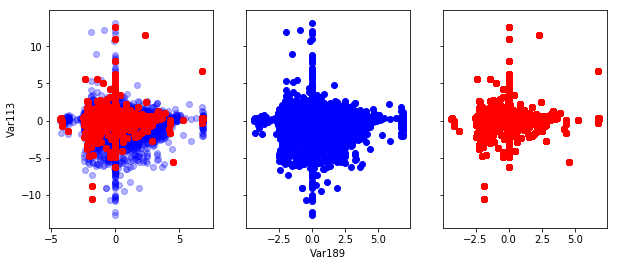

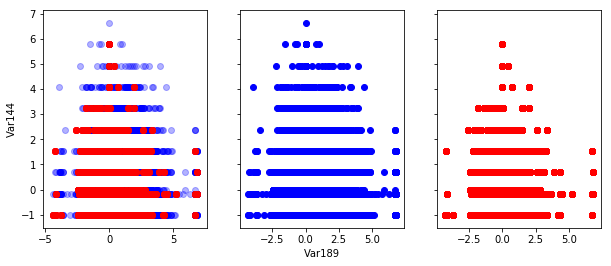

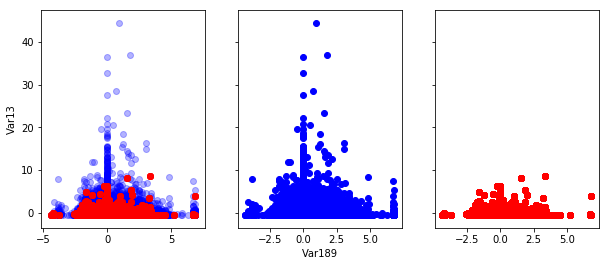

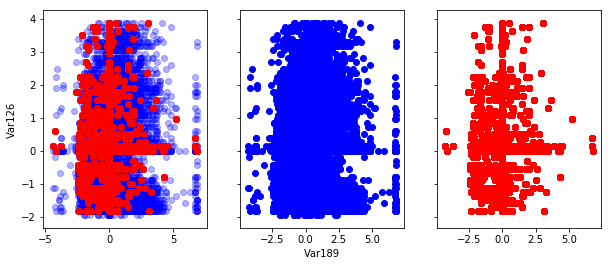

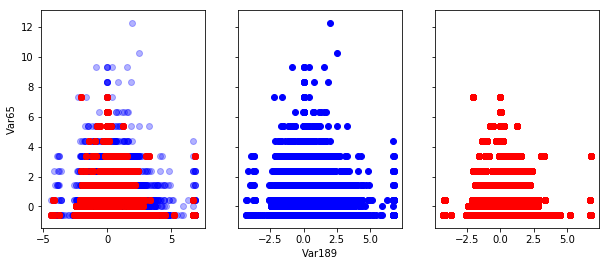

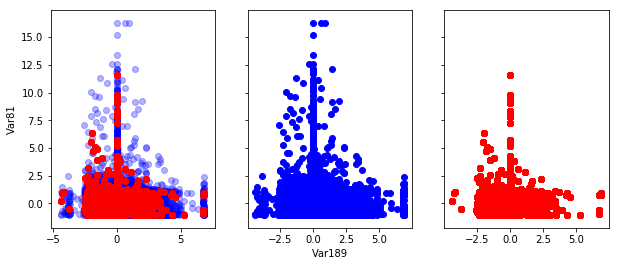

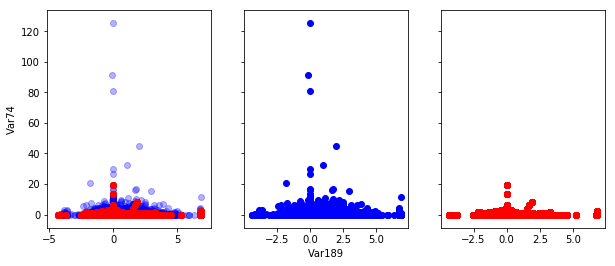

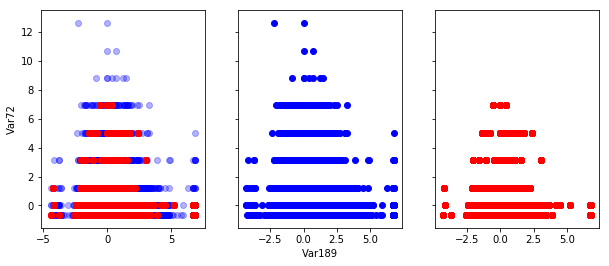

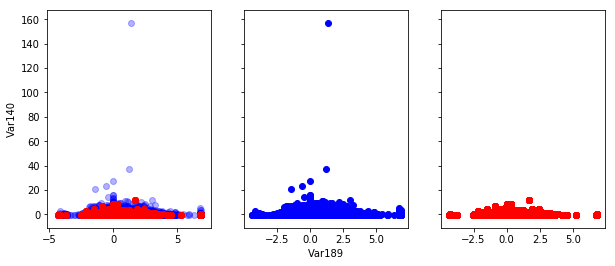

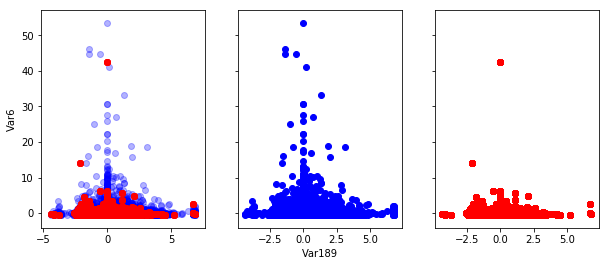

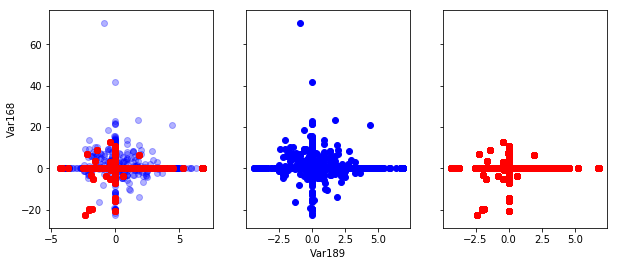

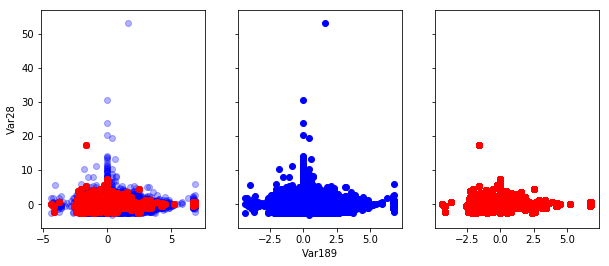

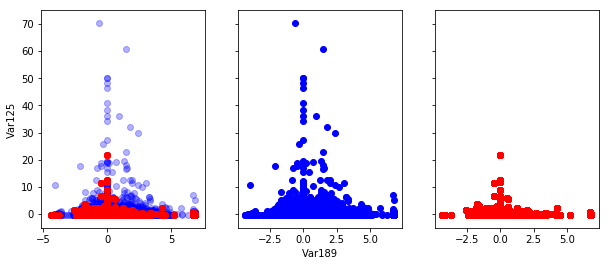

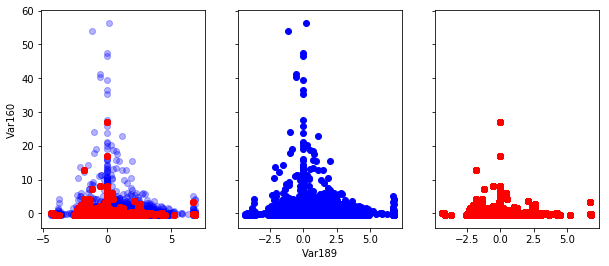

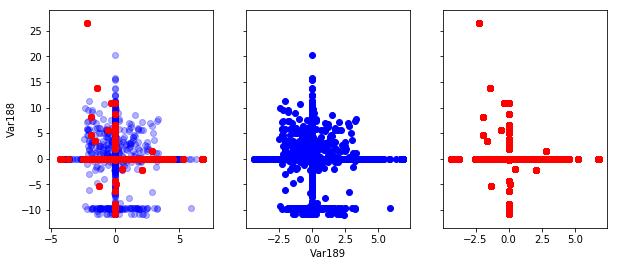

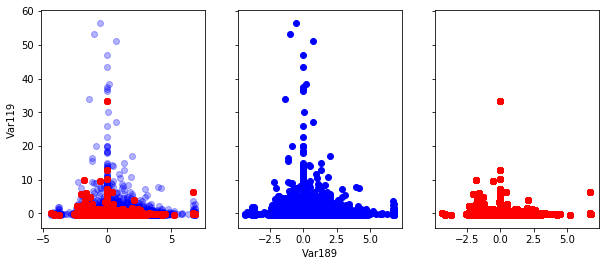

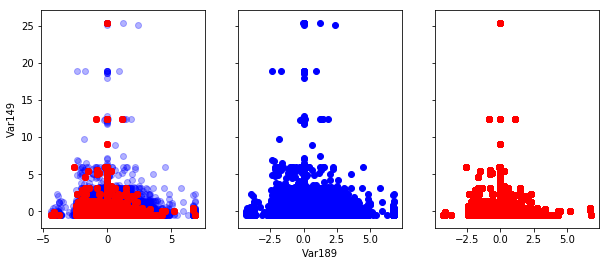

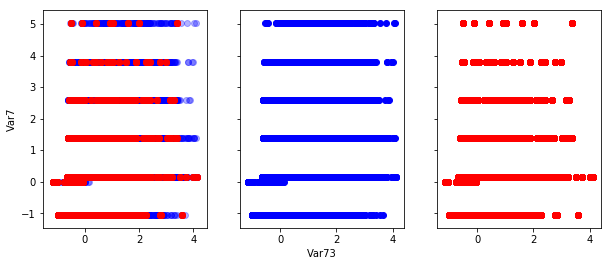

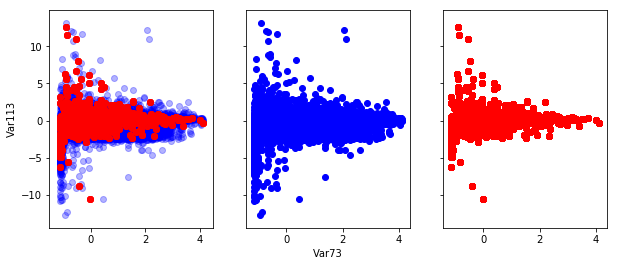

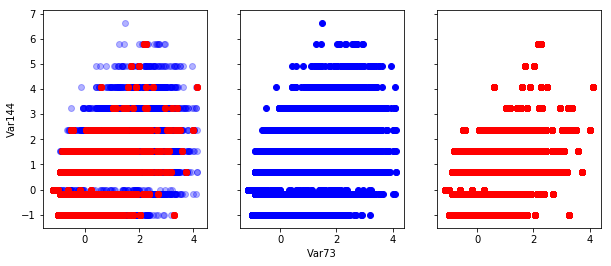

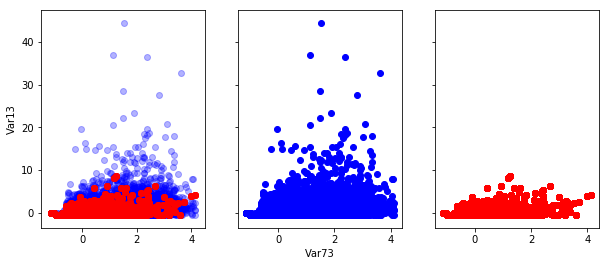

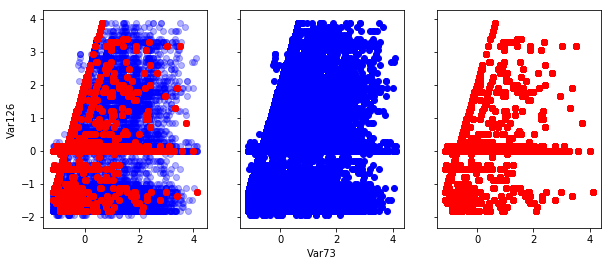

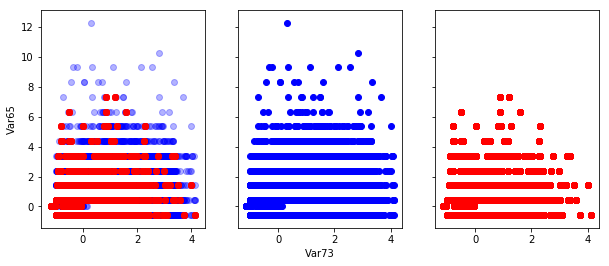

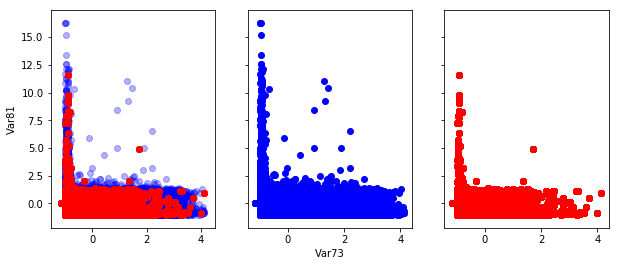

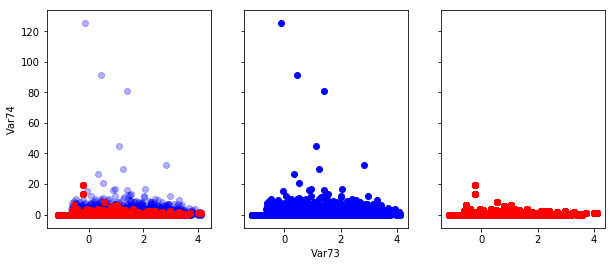

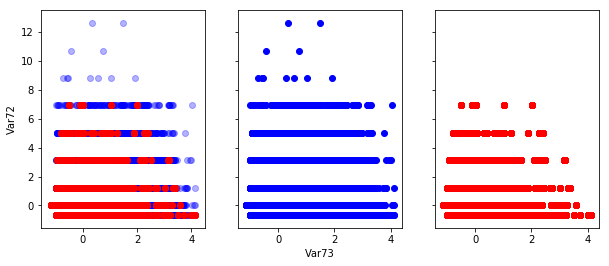

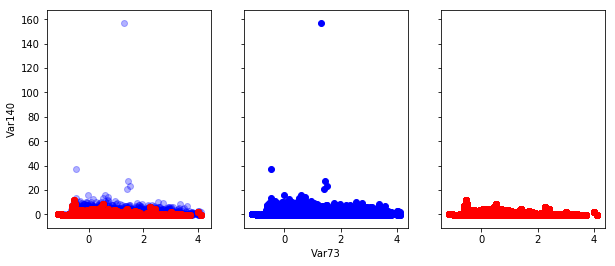

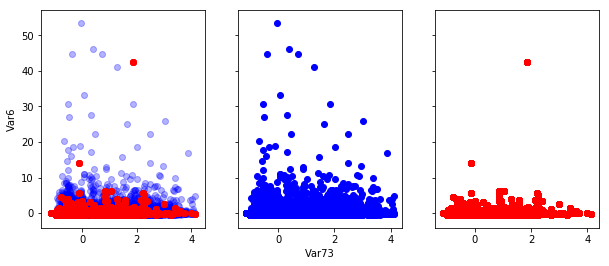

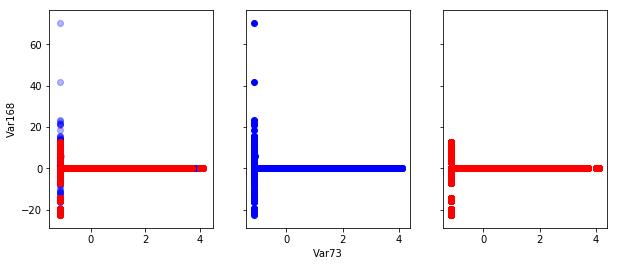

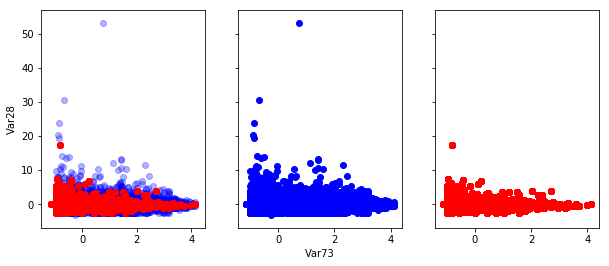

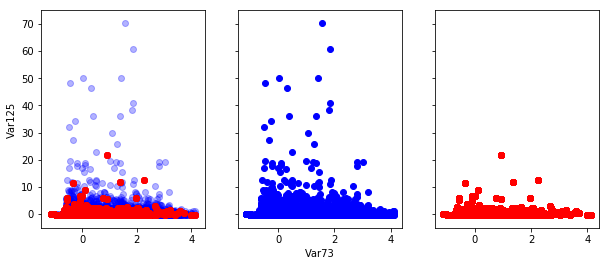

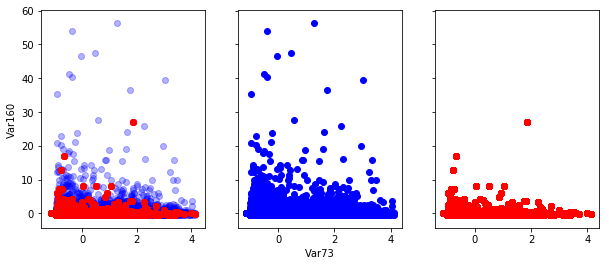

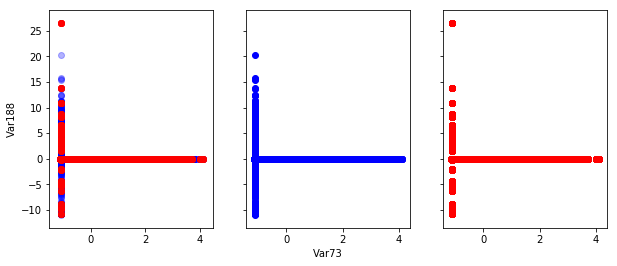

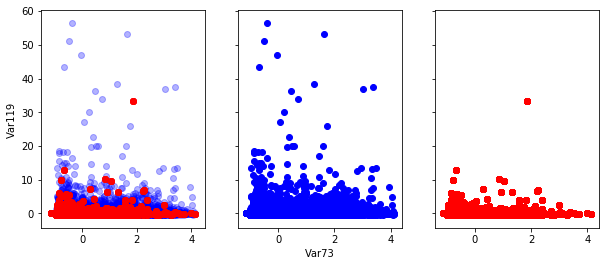

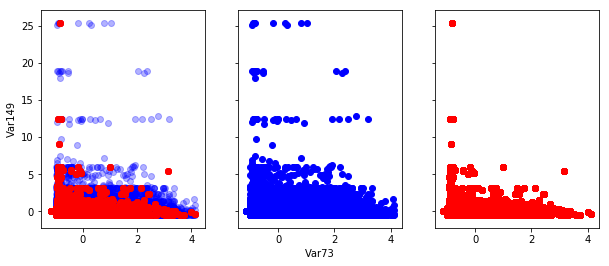

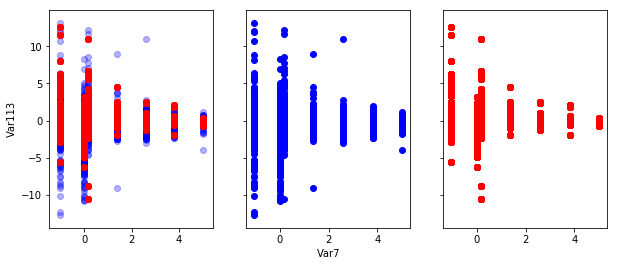

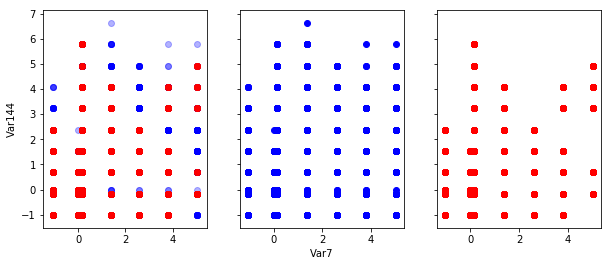

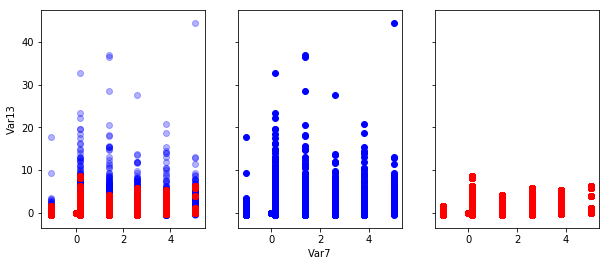

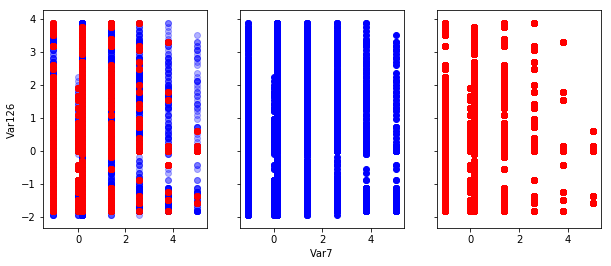

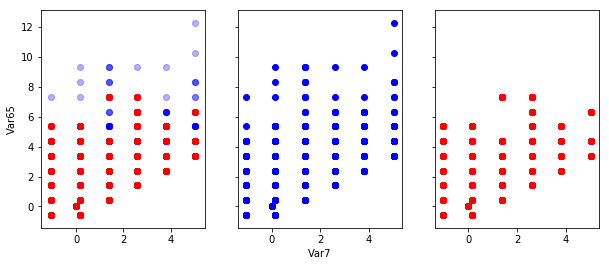

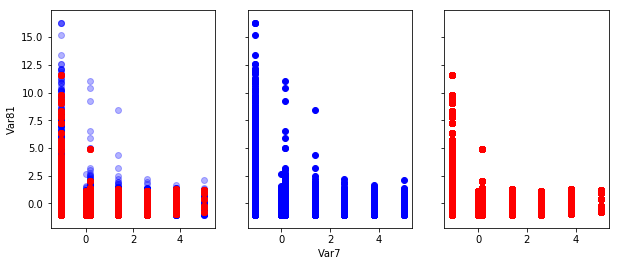

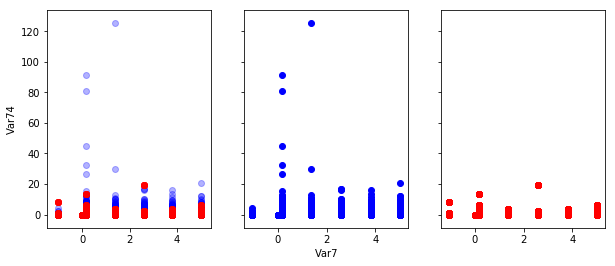

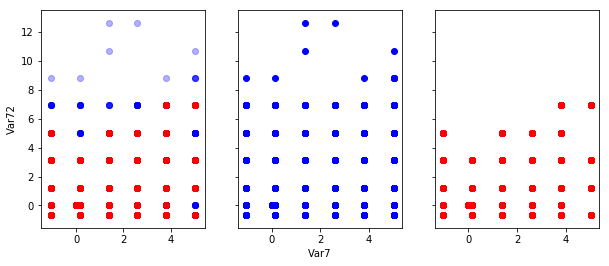

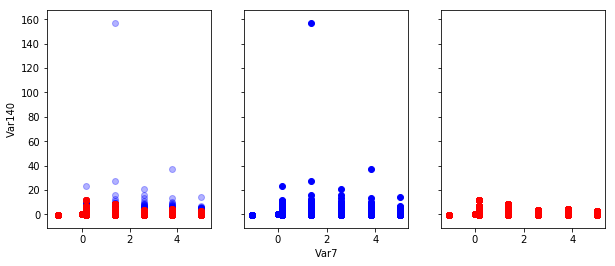

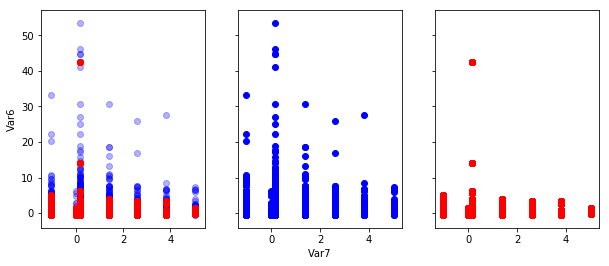

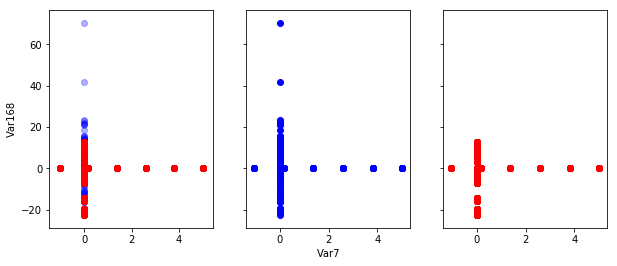

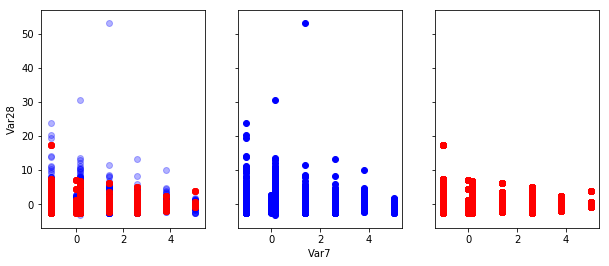

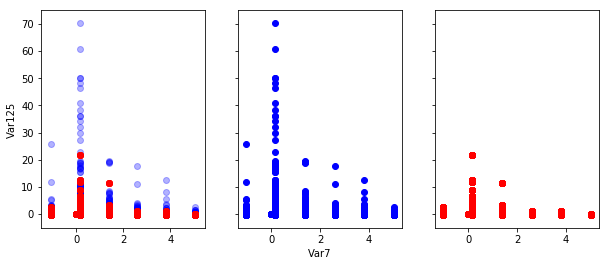

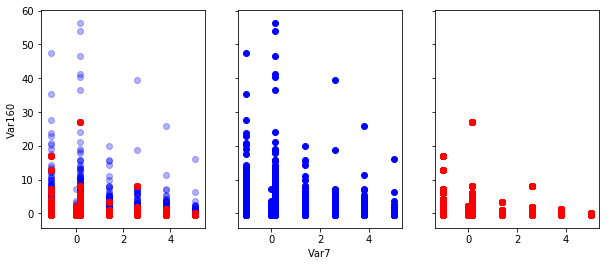

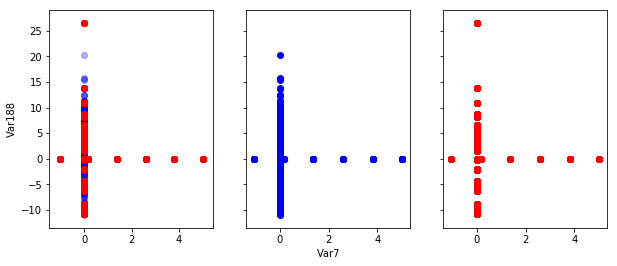

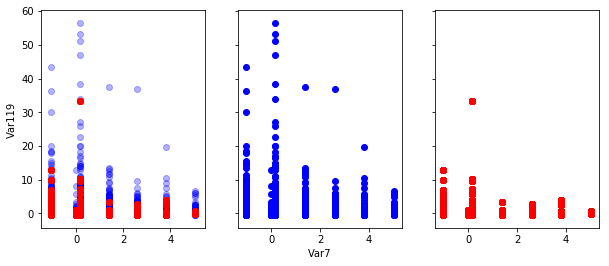

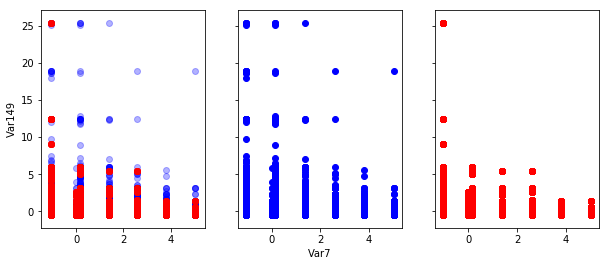

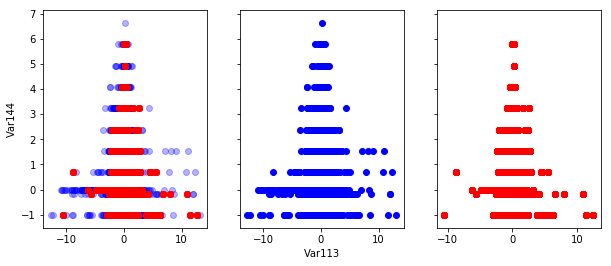

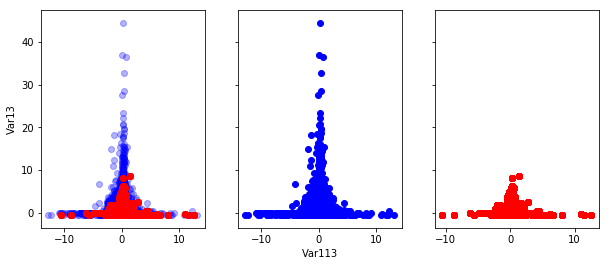

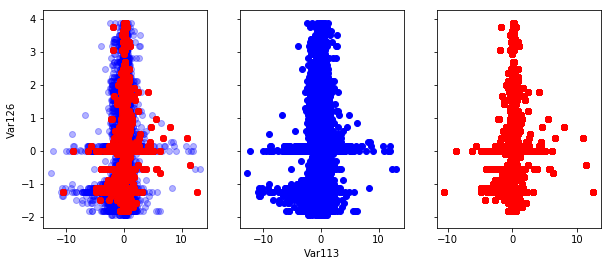

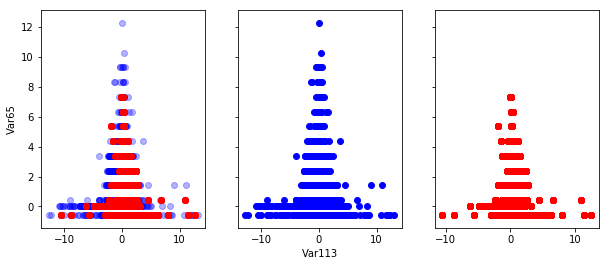

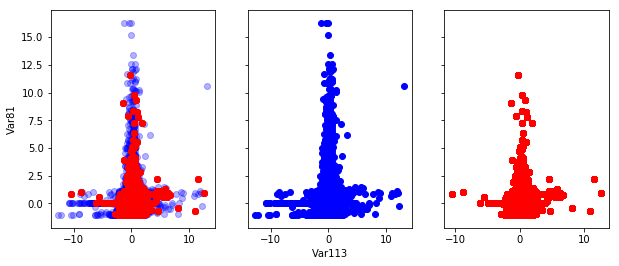

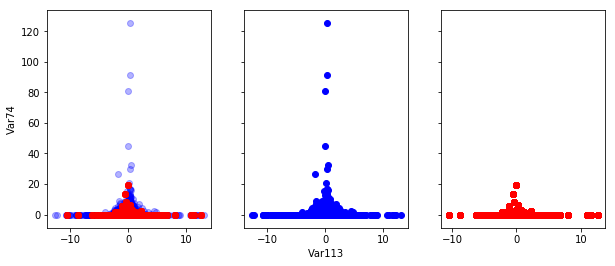

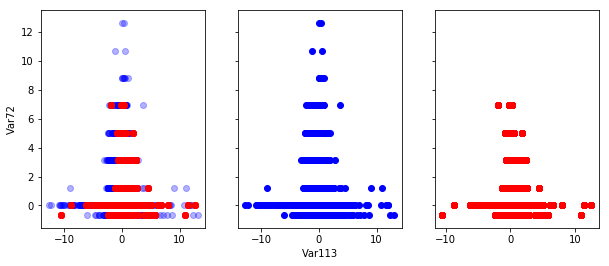

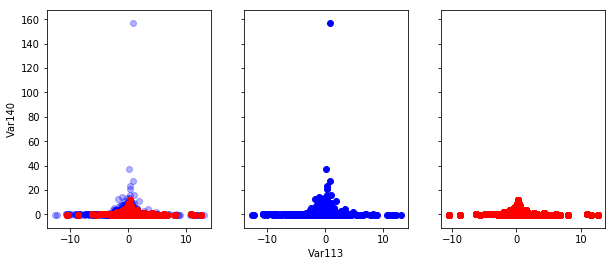

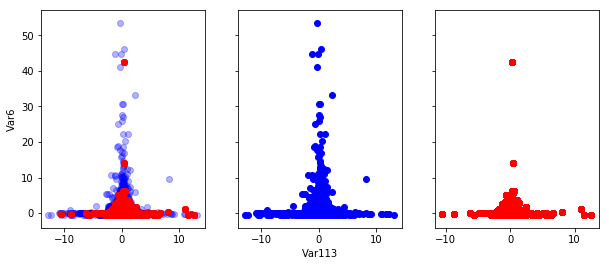

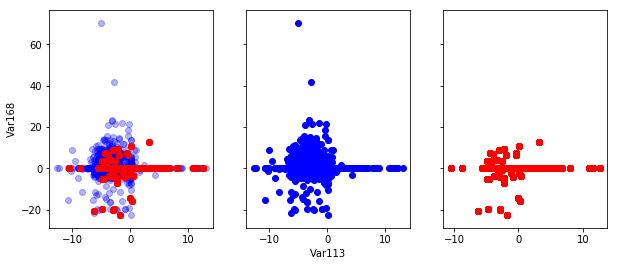

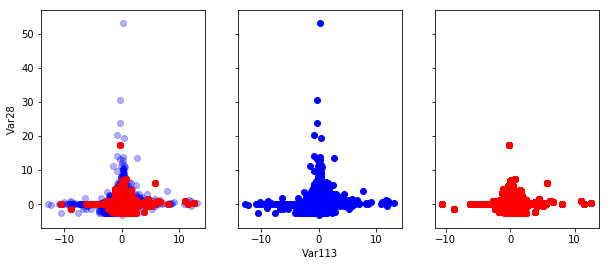

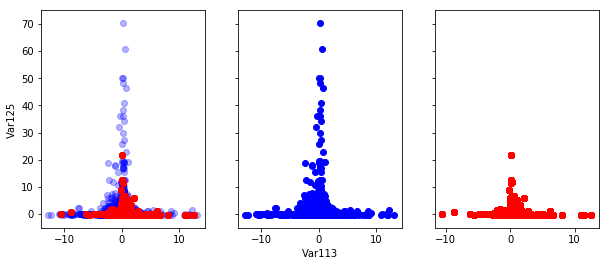

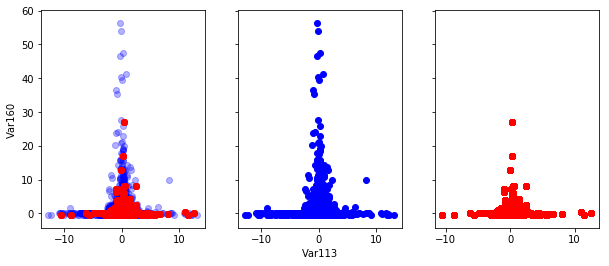

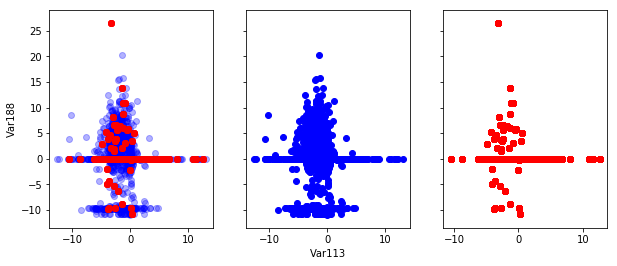

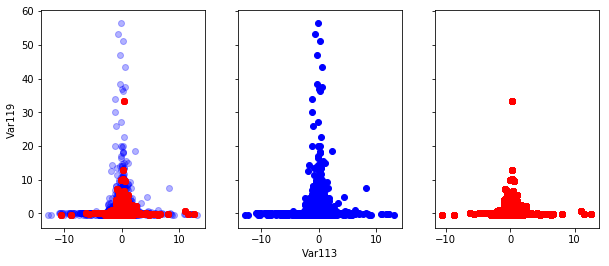

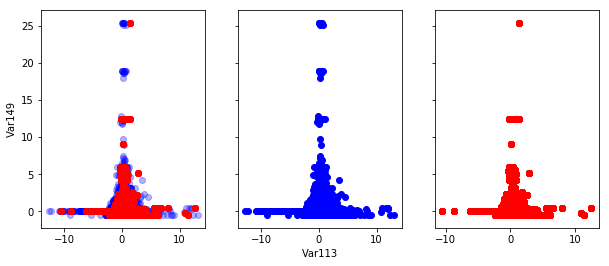

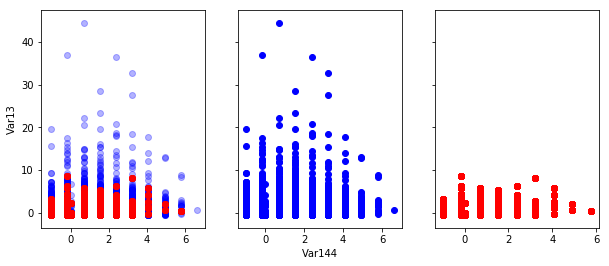

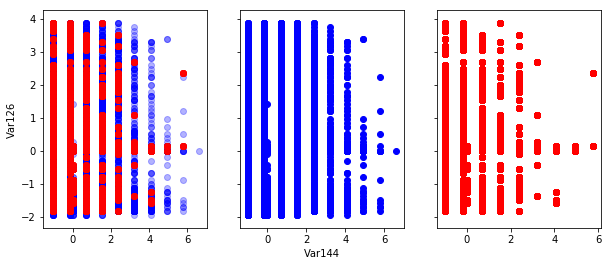

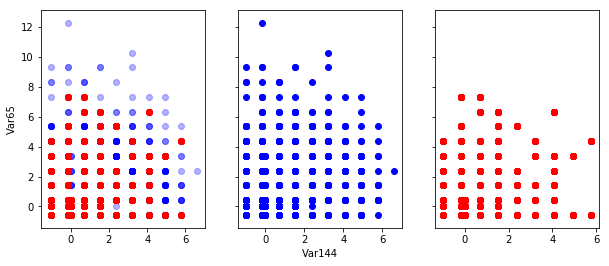

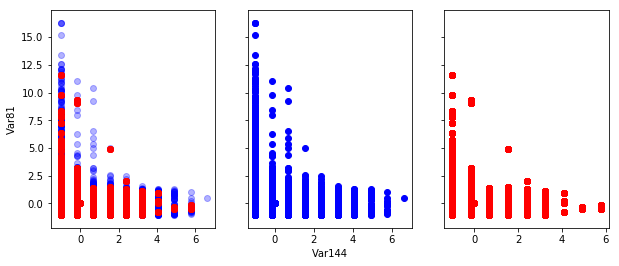

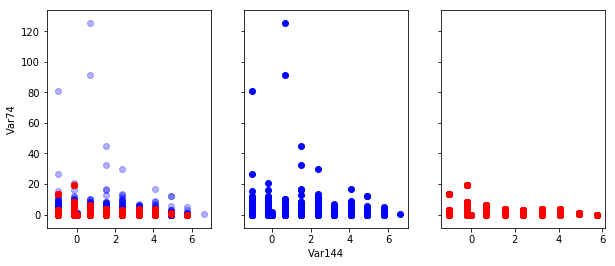

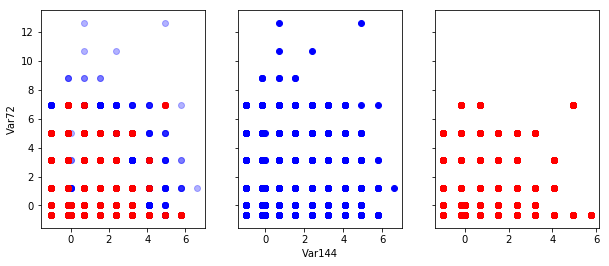

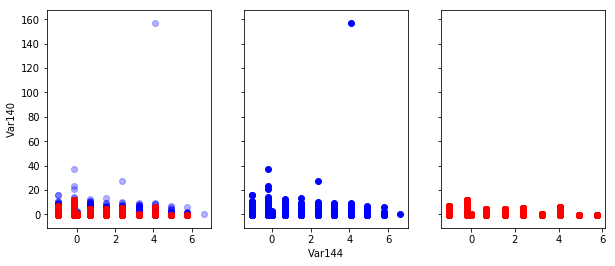

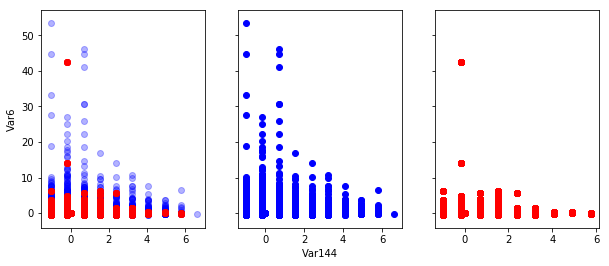

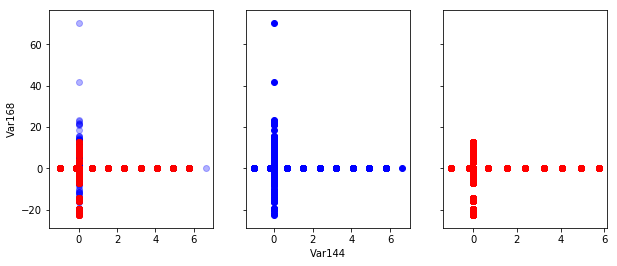

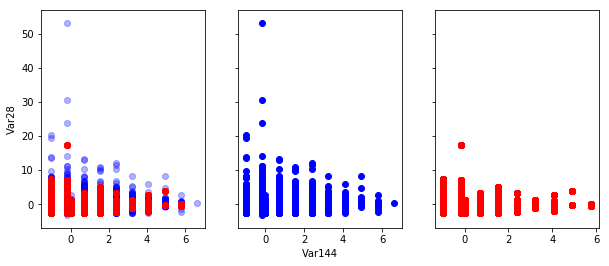

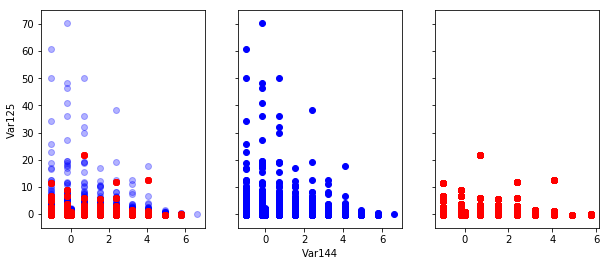

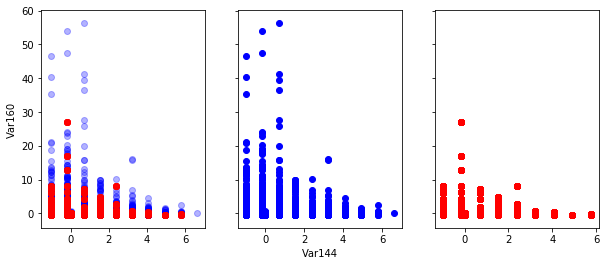

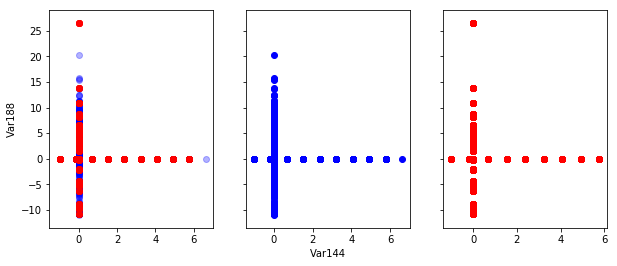

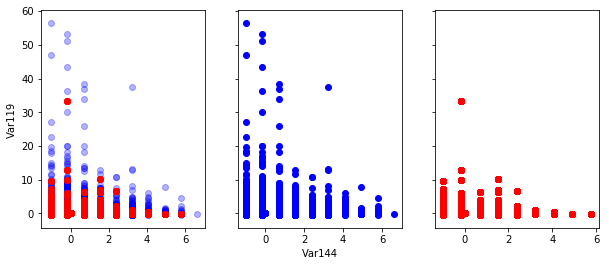

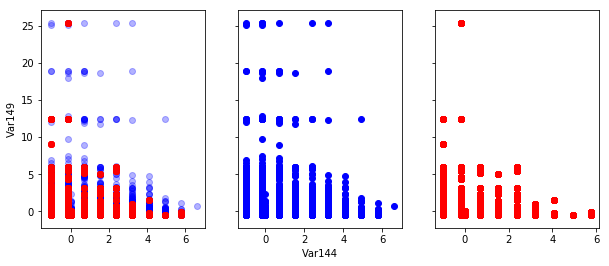

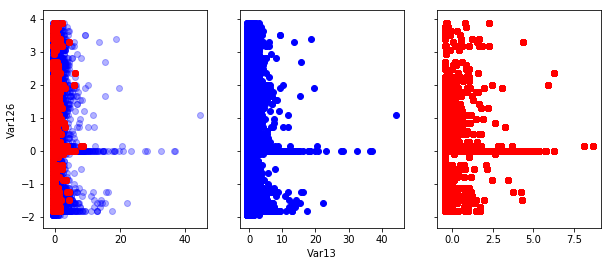

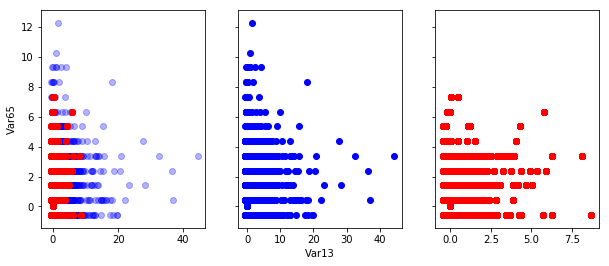

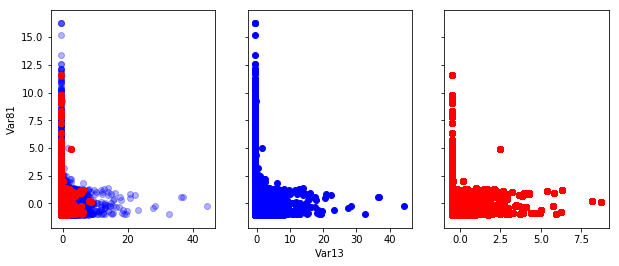

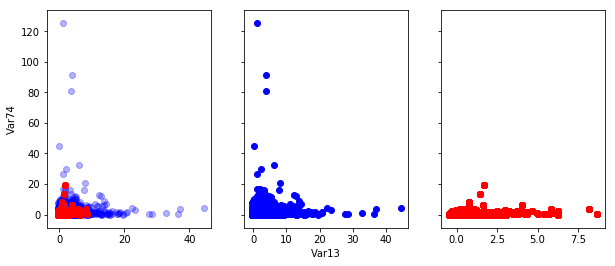

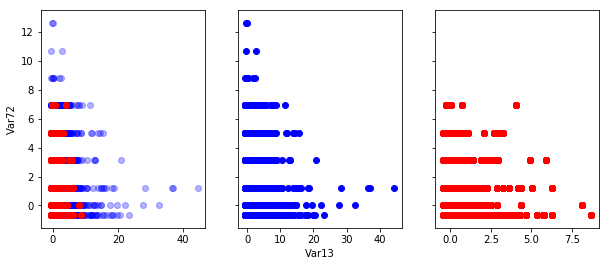

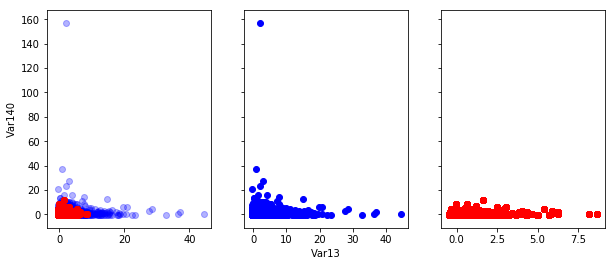

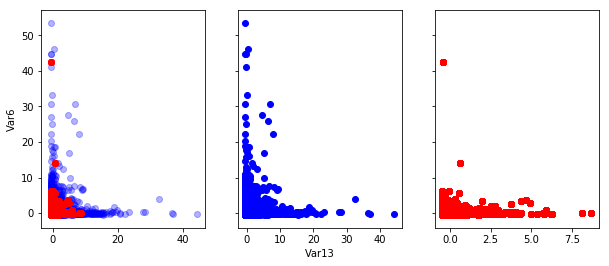

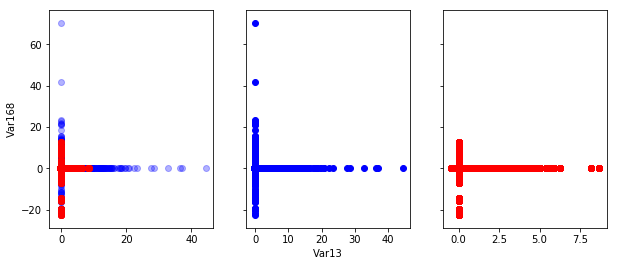

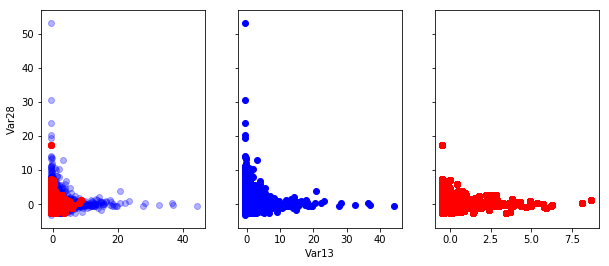

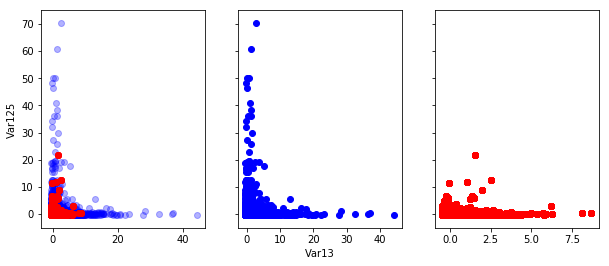

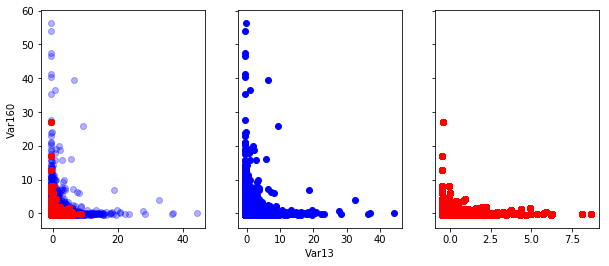

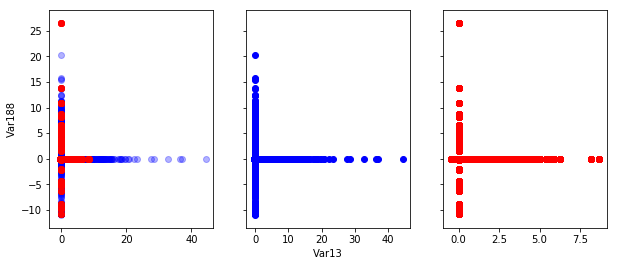

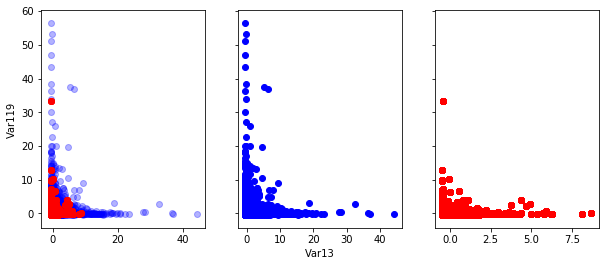

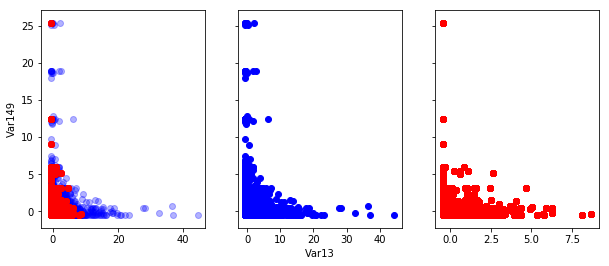

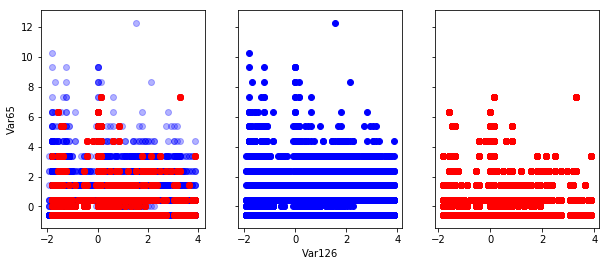

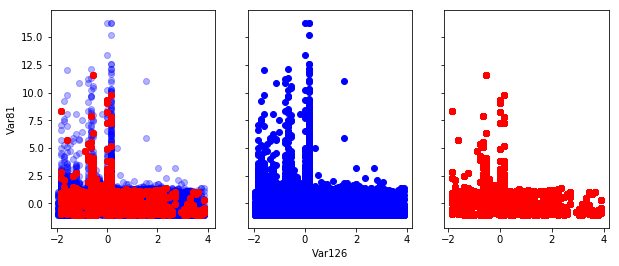

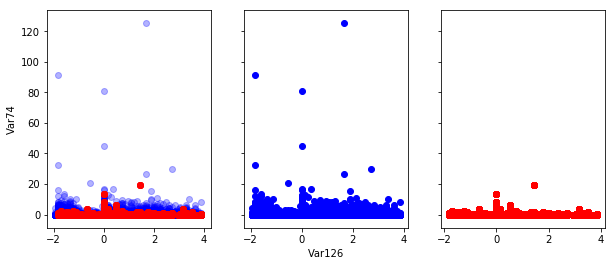

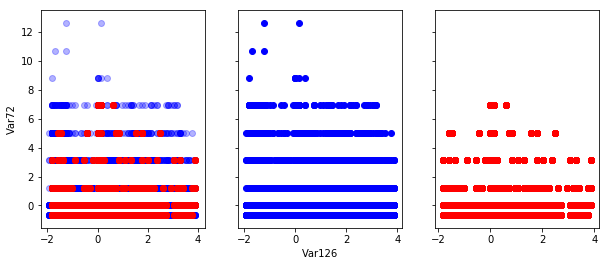

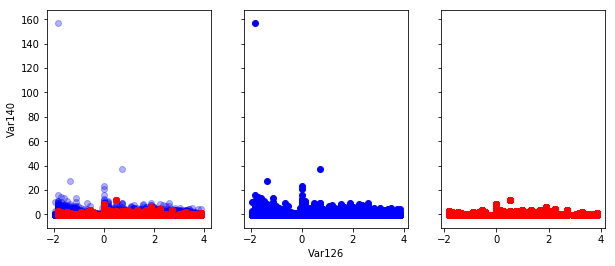

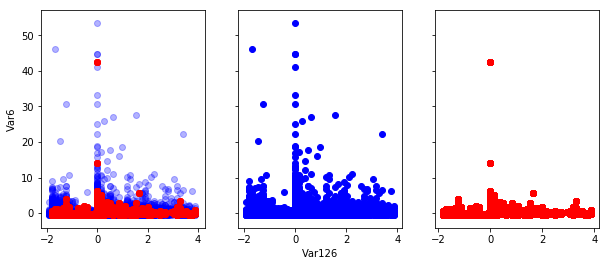

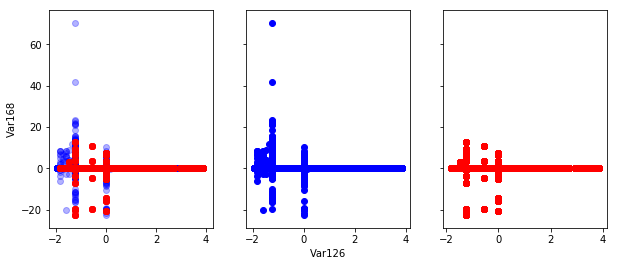

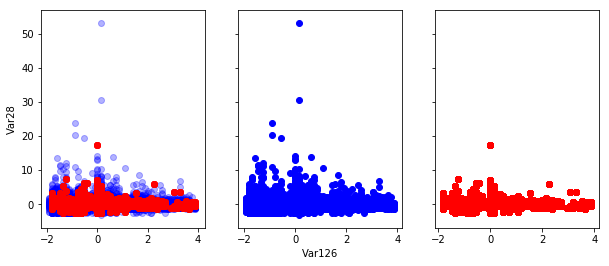

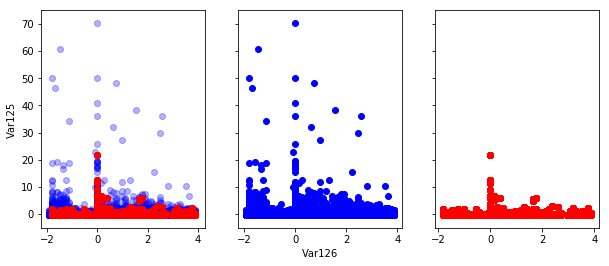

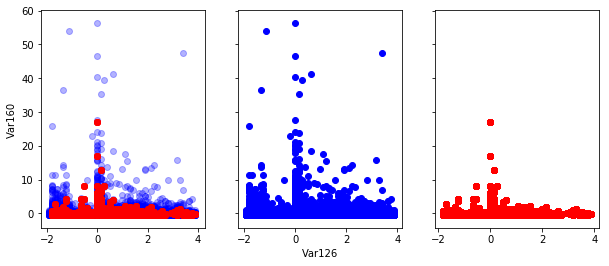

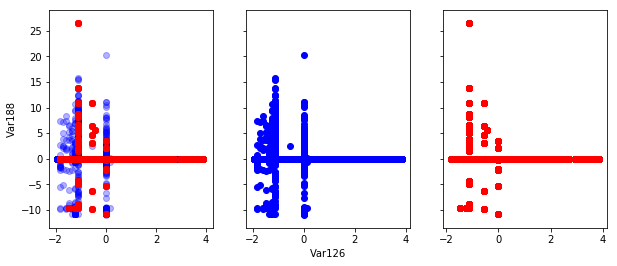

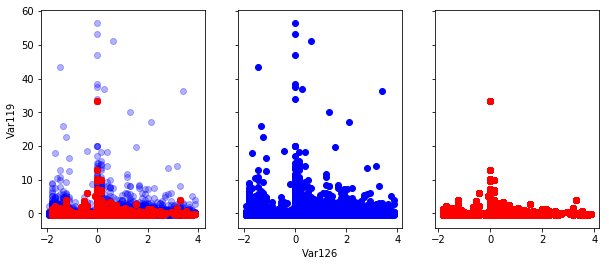

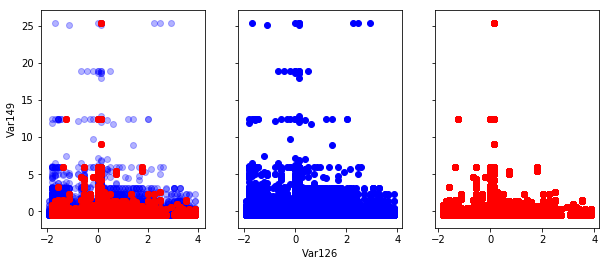

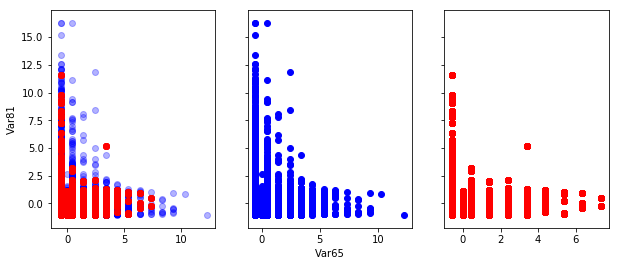

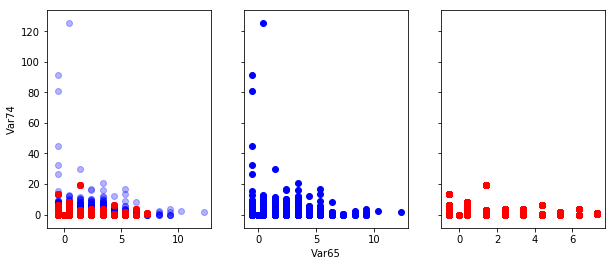

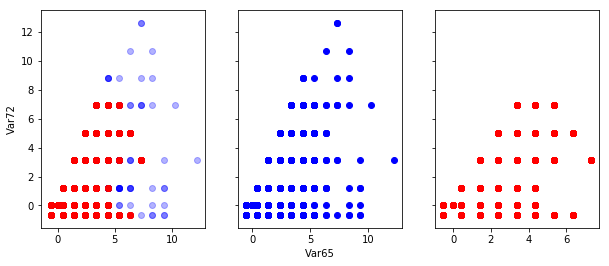

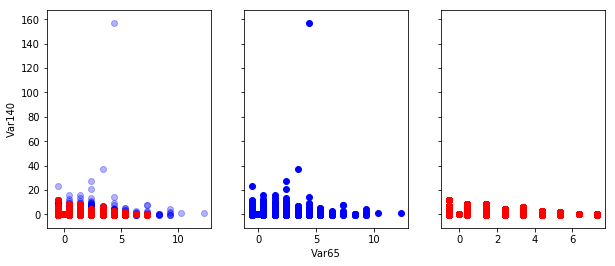

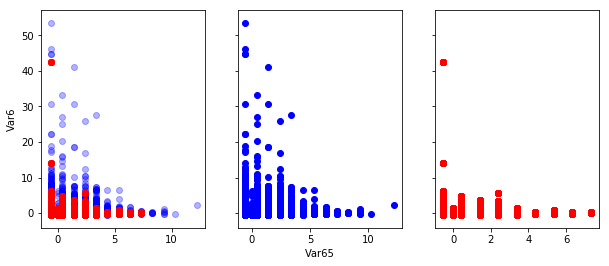

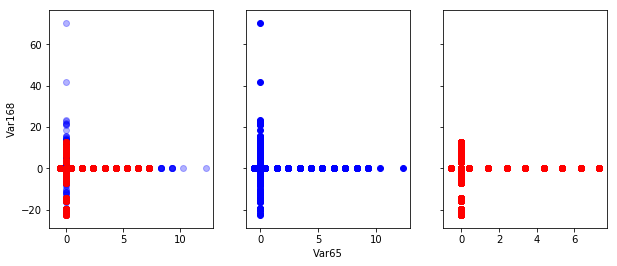

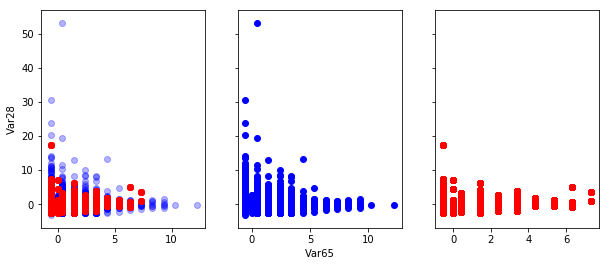

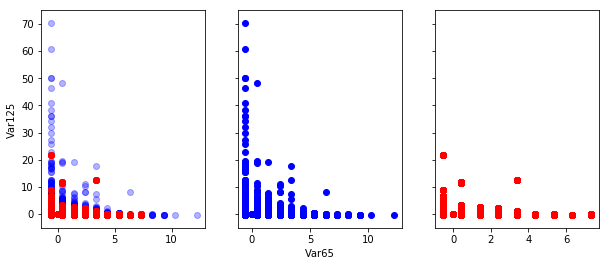

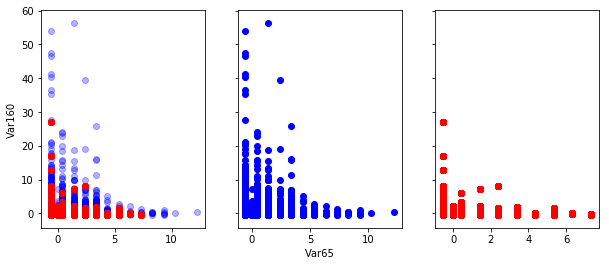

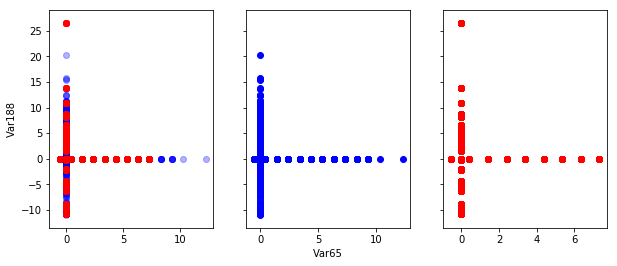

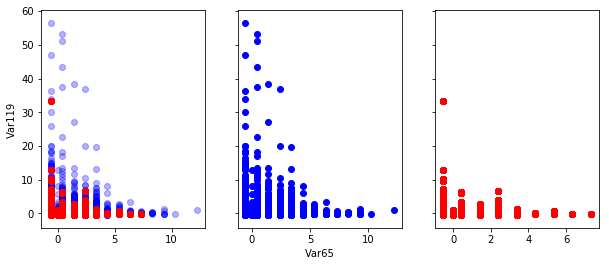

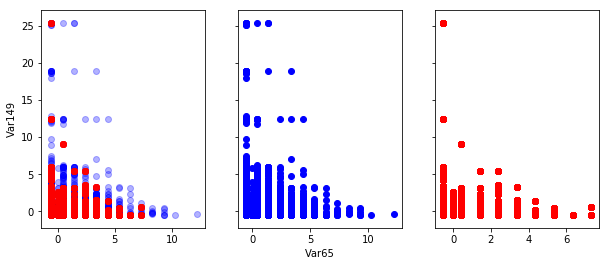

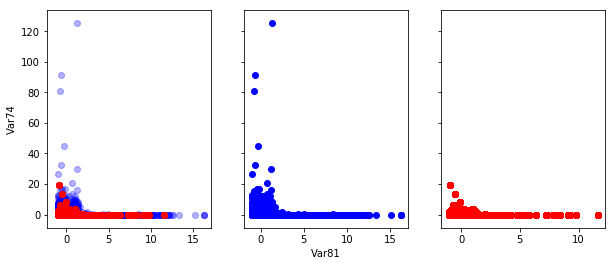

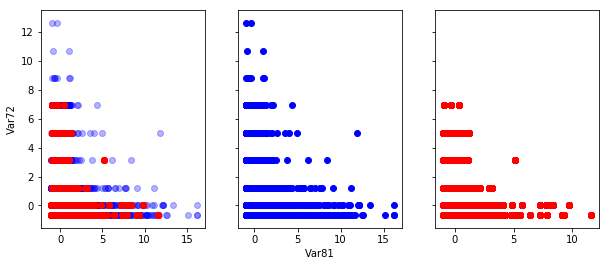

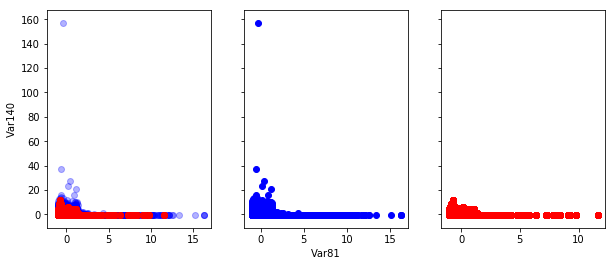

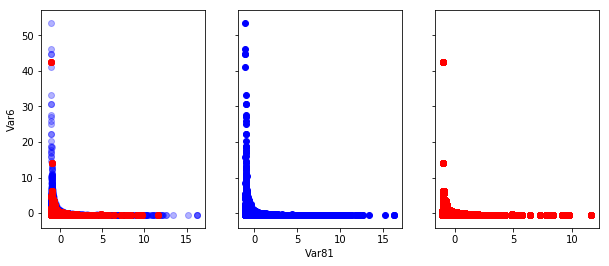

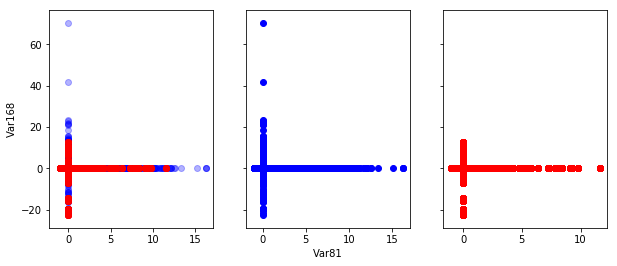

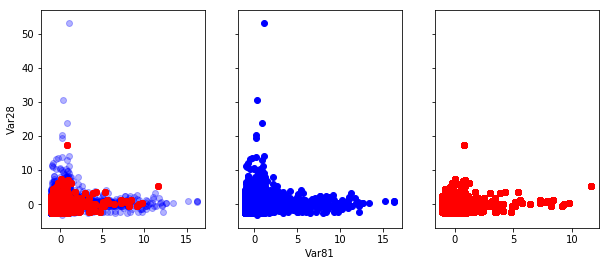

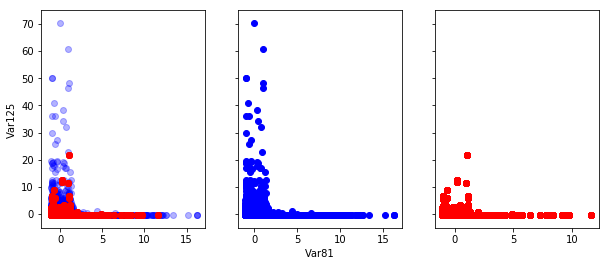

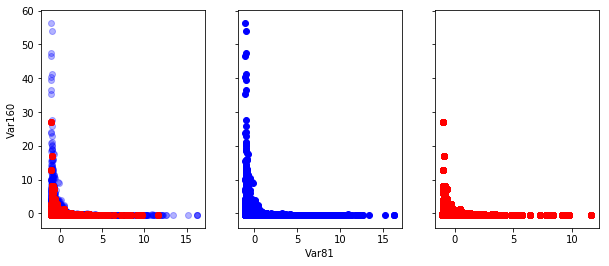

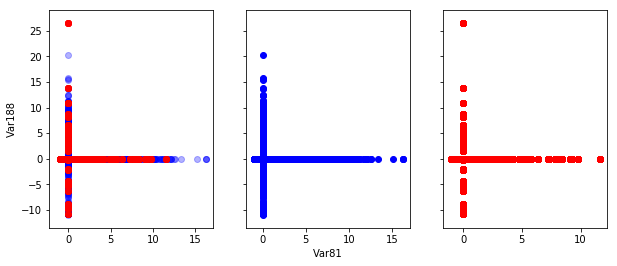

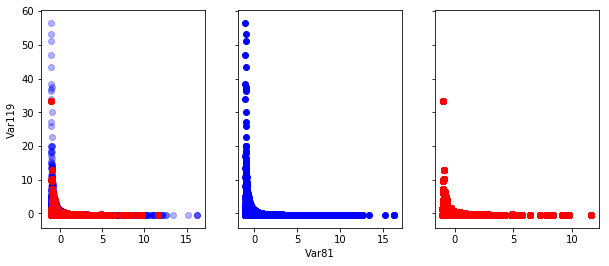

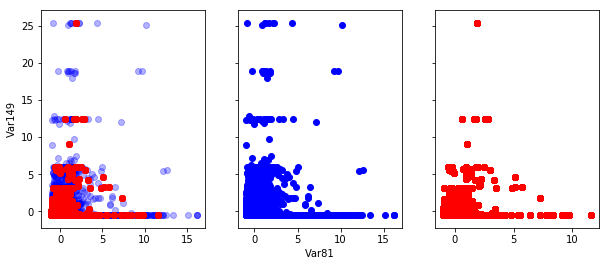

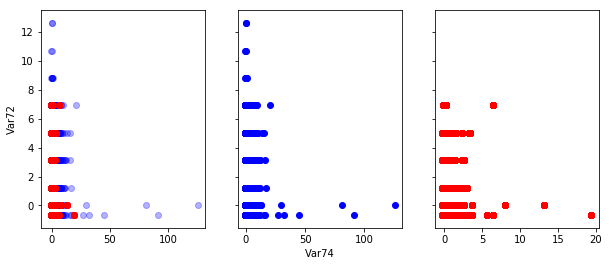

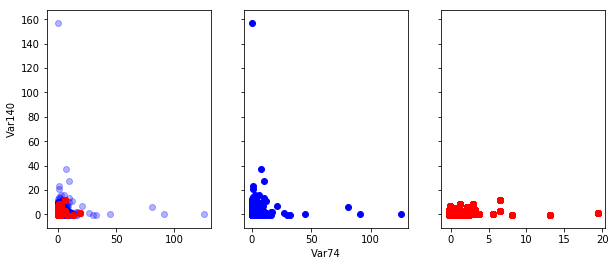

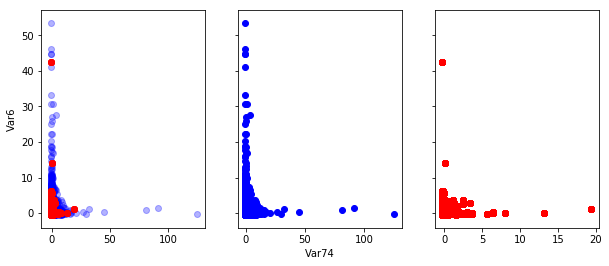

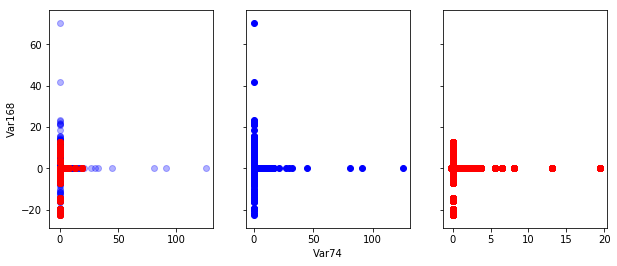

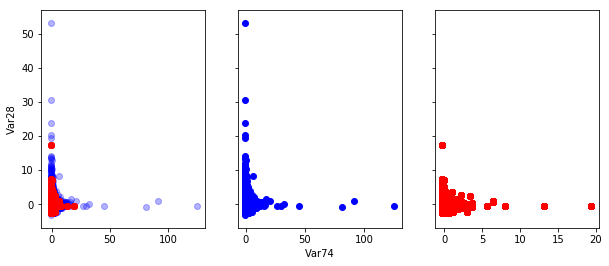

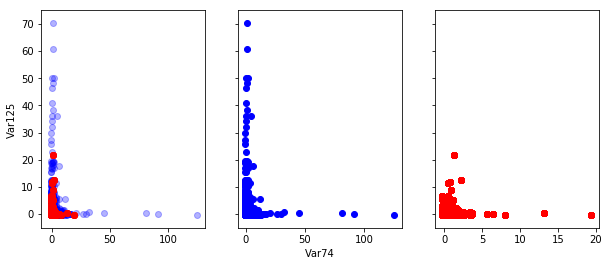

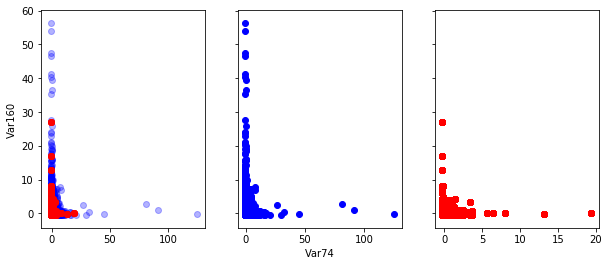

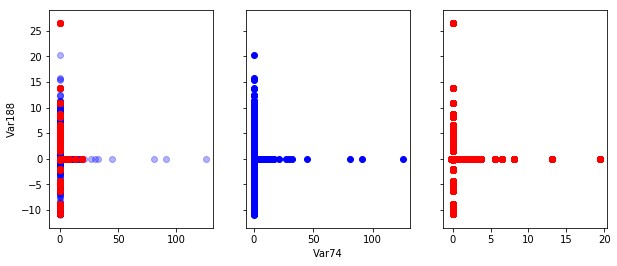

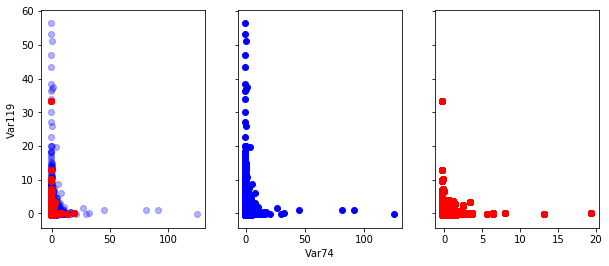

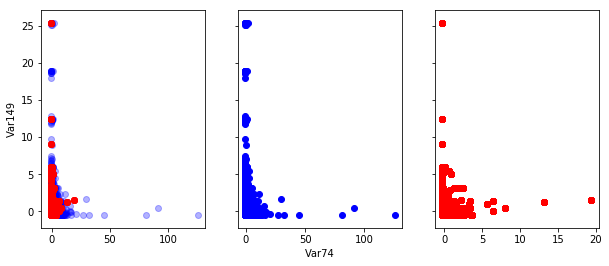

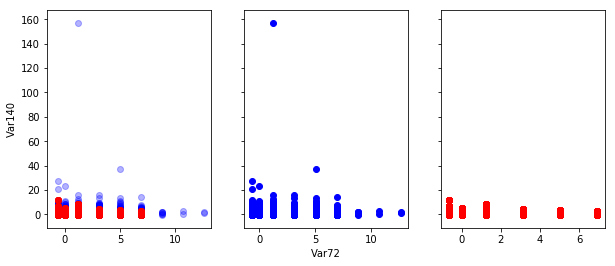

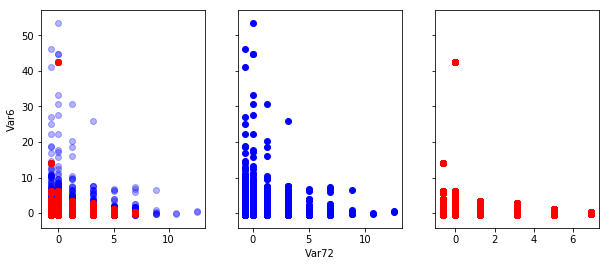

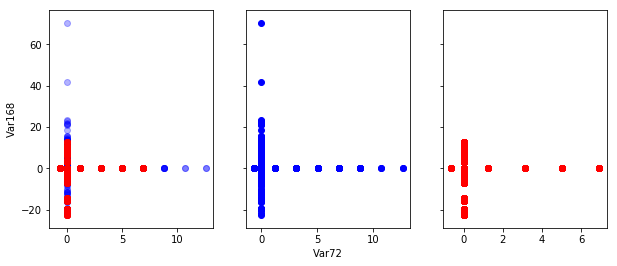

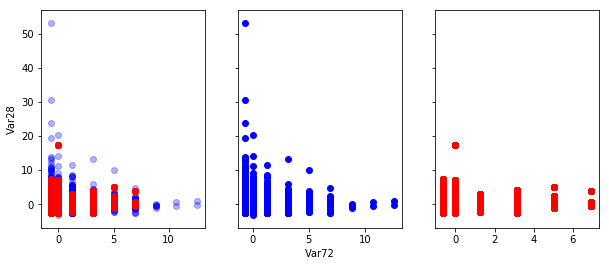

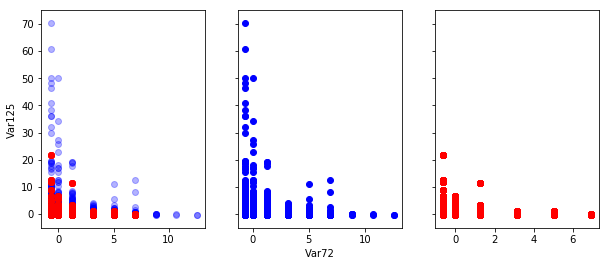

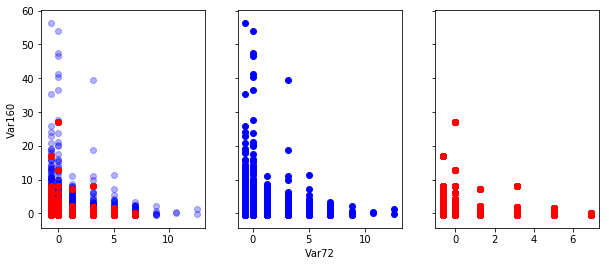

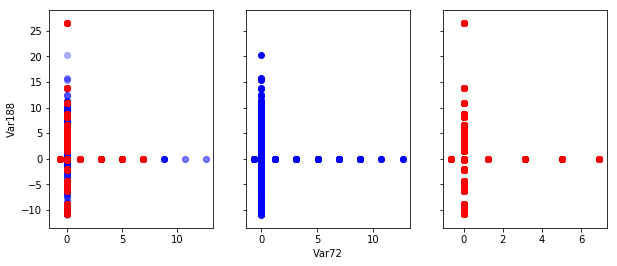

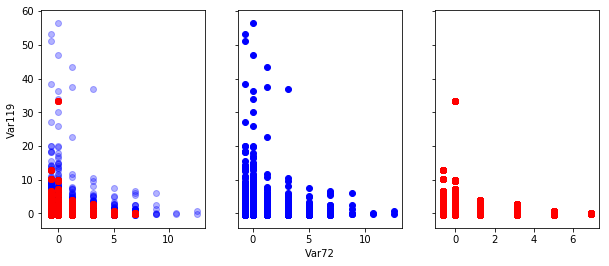

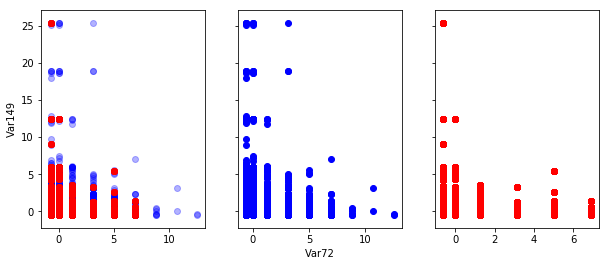

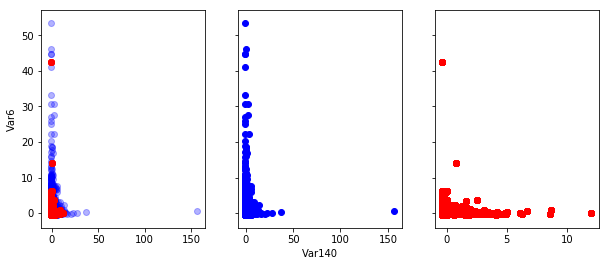

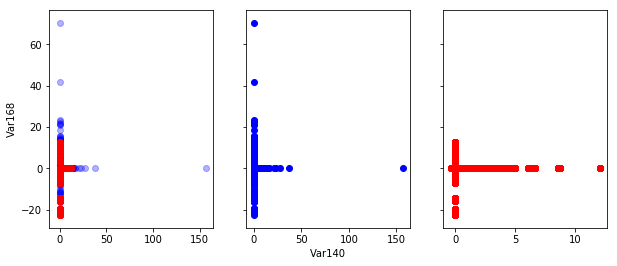

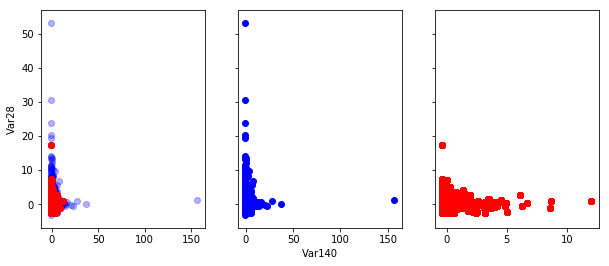

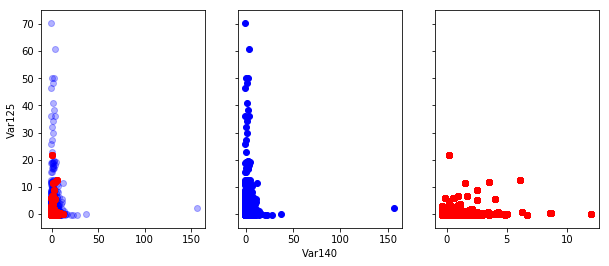

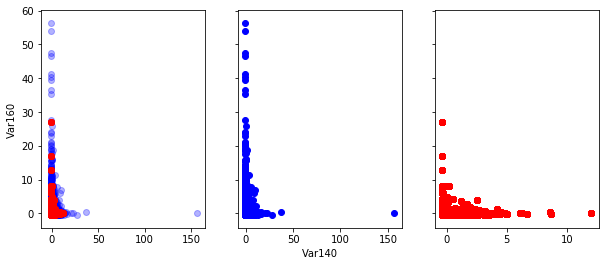

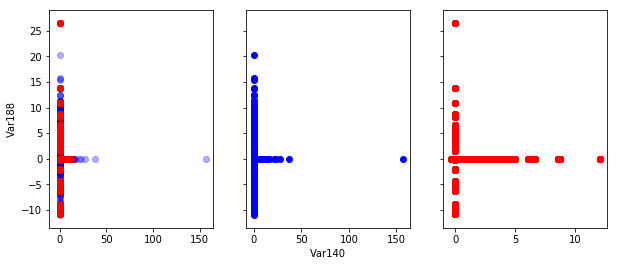

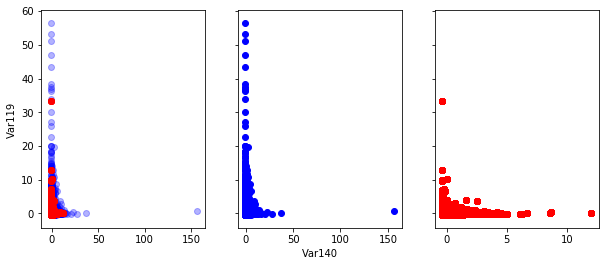

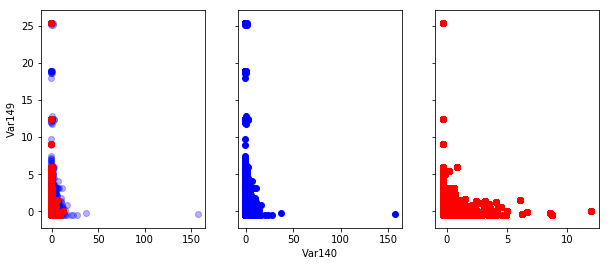

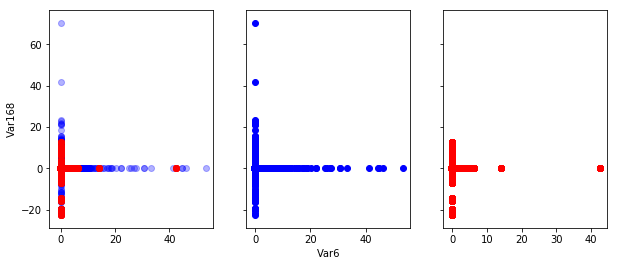

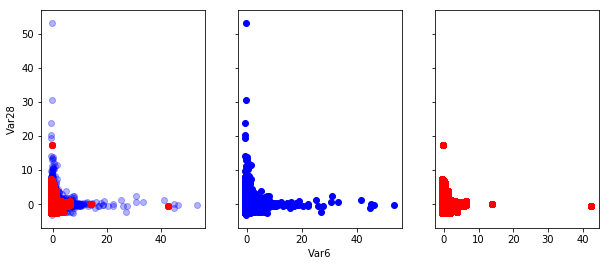

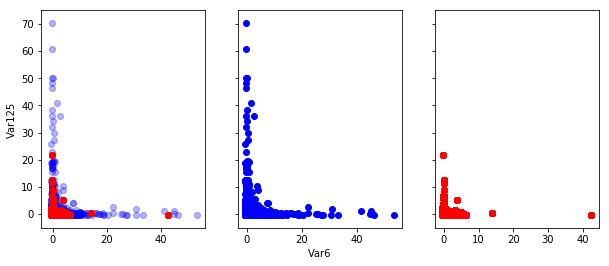

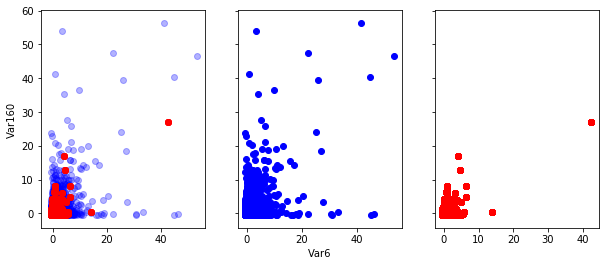

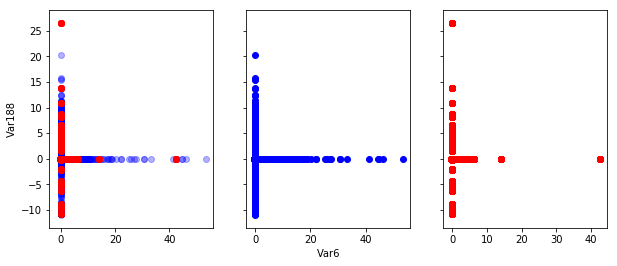

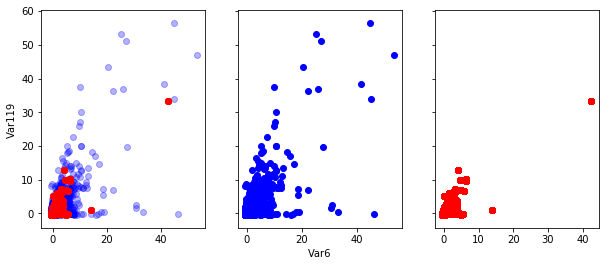

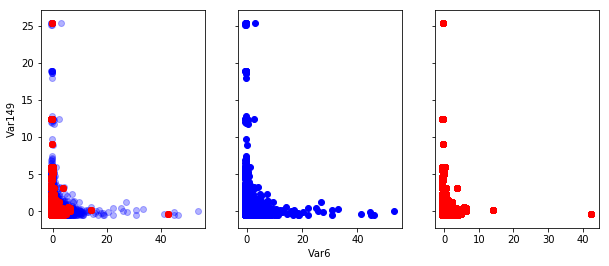

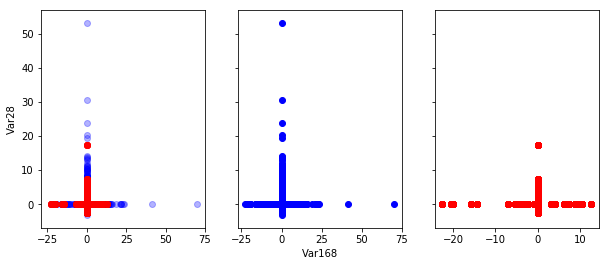

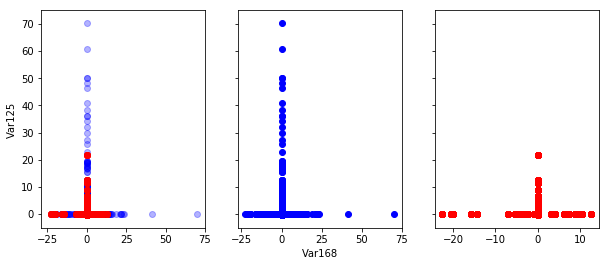

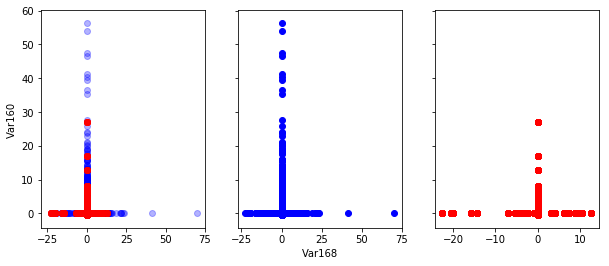

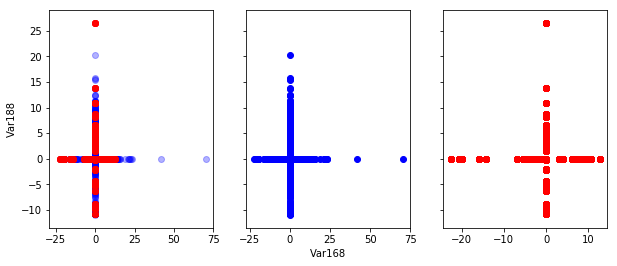

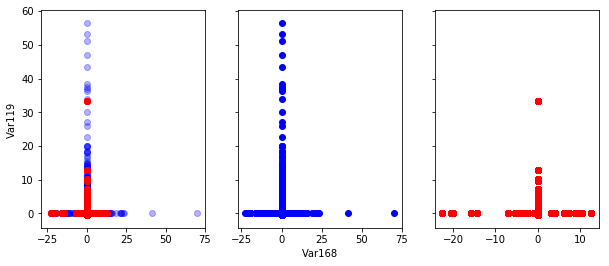

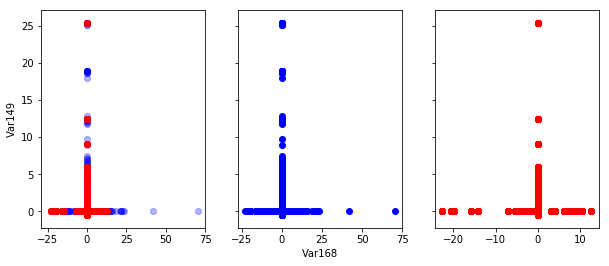

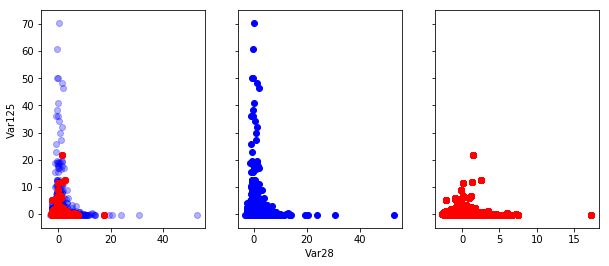

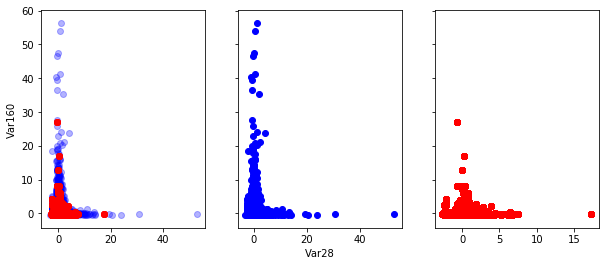

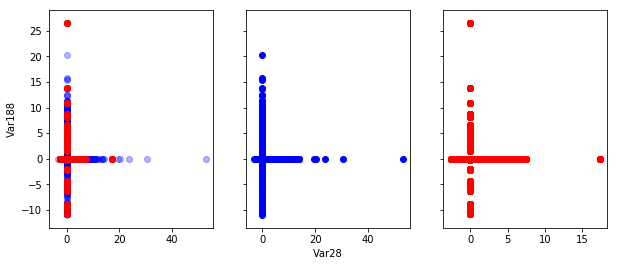

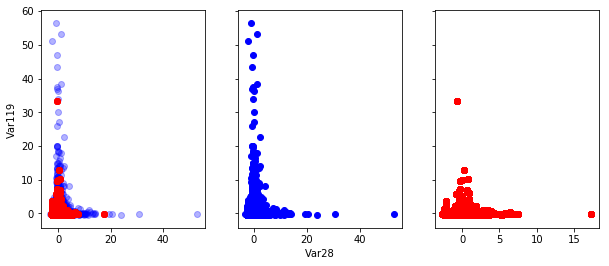

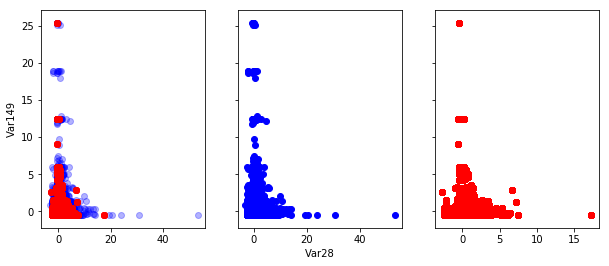

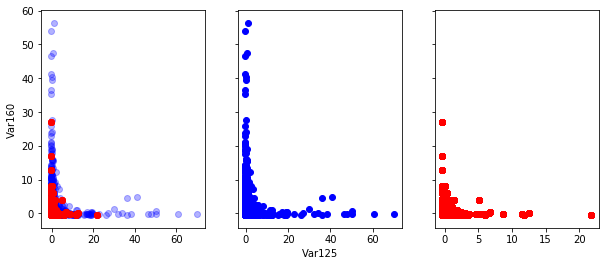

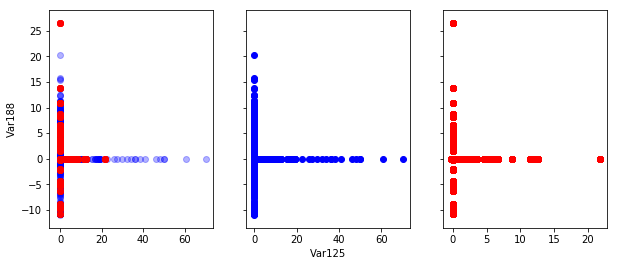

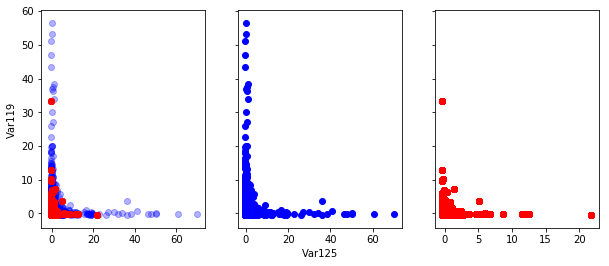

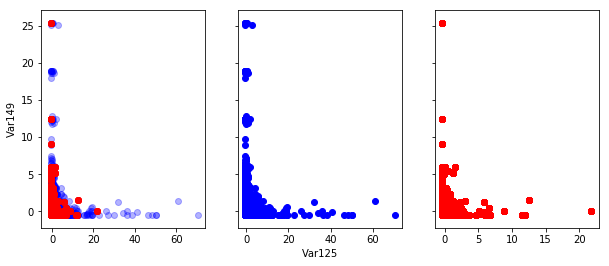

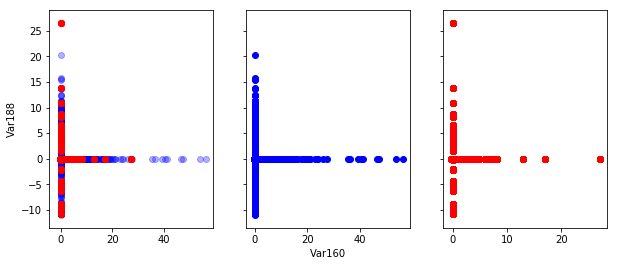

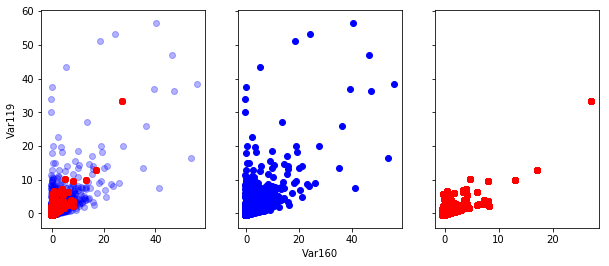

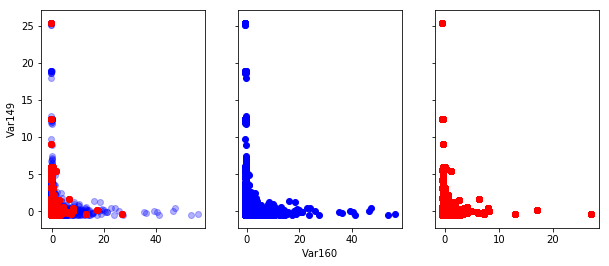

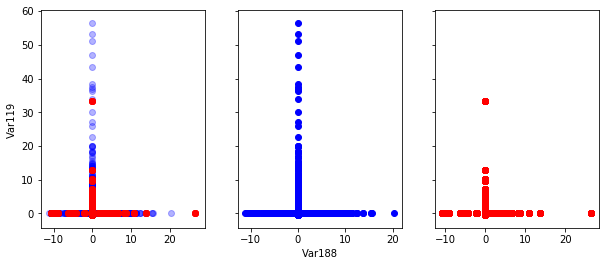

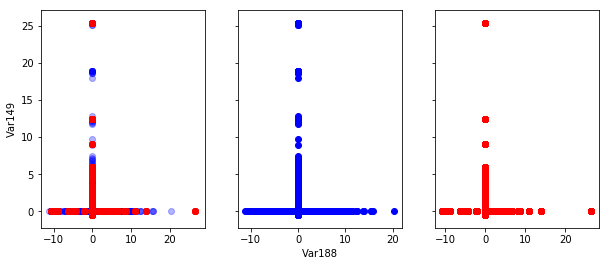

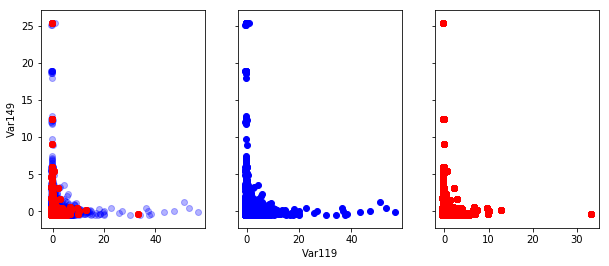

In [15]:
build_scatter_plots(
    numeric_balanced_frame,
    top_columns,
    class_descriptions)

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [16]:
# Уберем из списка взаимосвязей top_columns и bottom_columns, т.к. мы их рассмотрим в заданиях 4 и 6
middle_interrelations = interrelations.drop(labels=top_balanced_columns, axis=0)
middle_interrelations = middle_interrelations.drop(labels=bottom_balanced_columns, axis=0)

In [17]:
# Сгенерируем случайный список из 10 индексов числовых признаков и выберем их
random_indices = random.sample(range(middle_interrelations.index.shape[0]), 10)
random_columns = middle_interrelations[random_indices].index

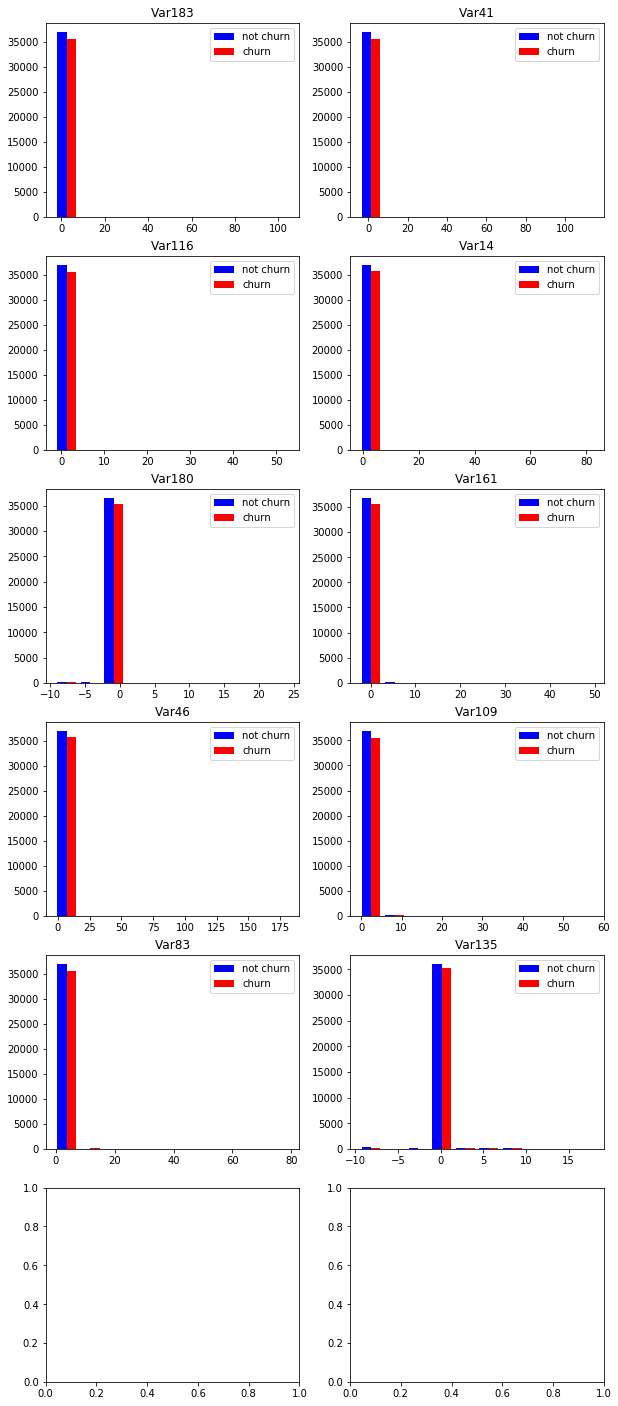

In [18]:
# Построим распределения
build_distribution_plots(numeric_balanced_frame, random_columns, class_descriptions)

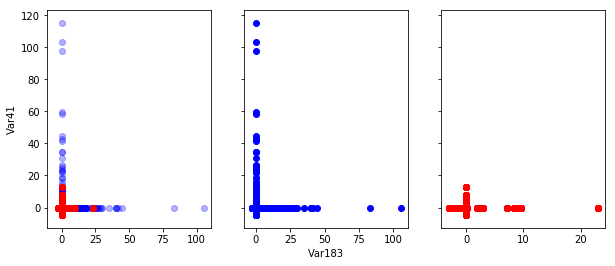

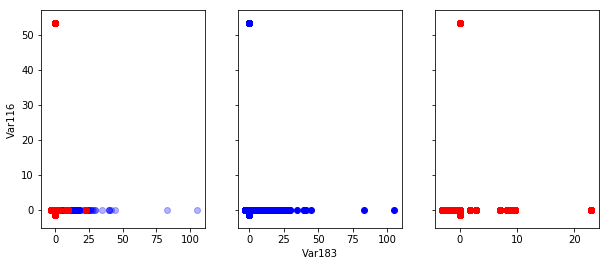

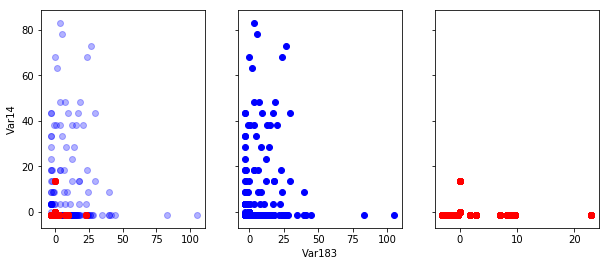

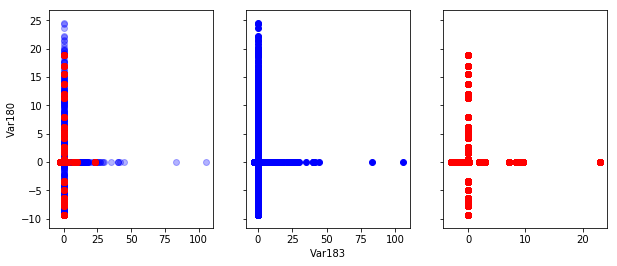

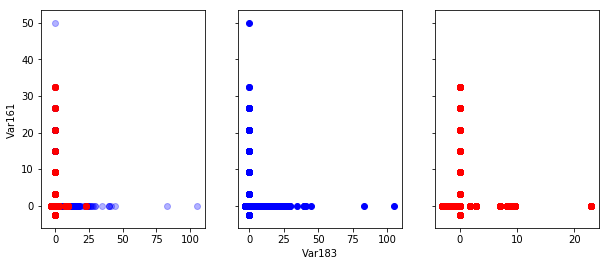

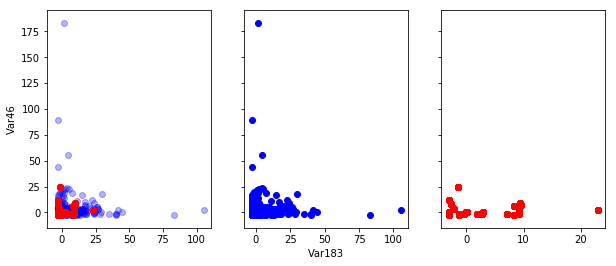

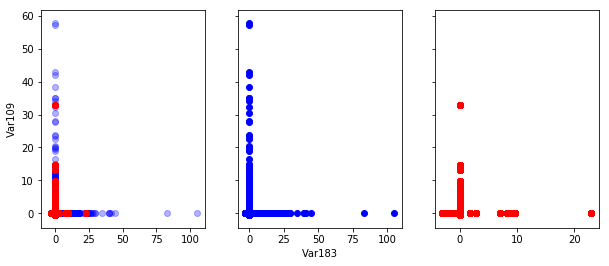

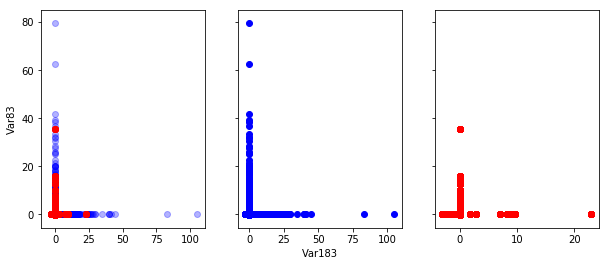

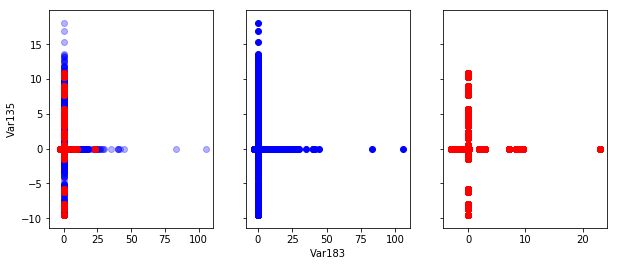

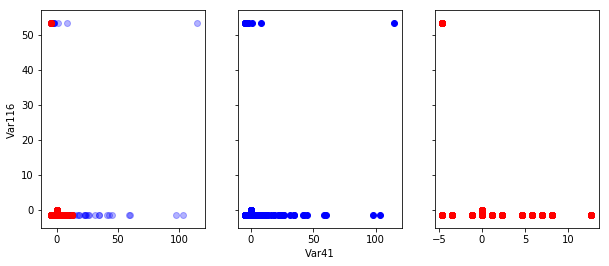

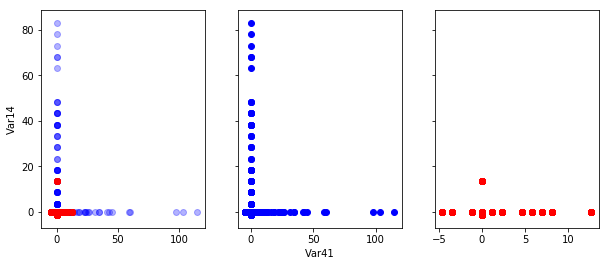

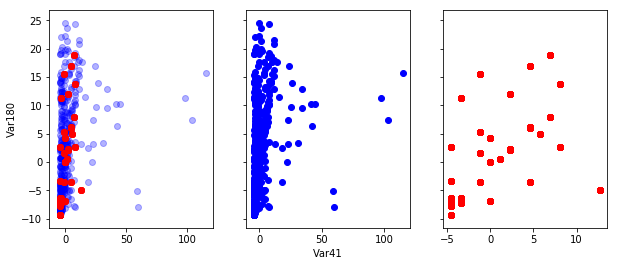

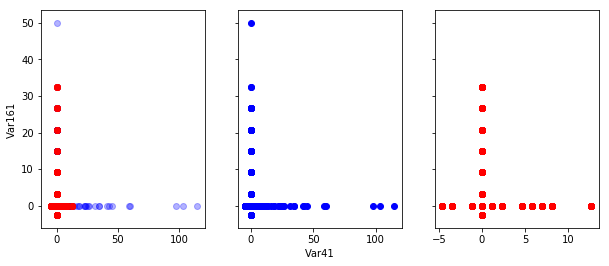

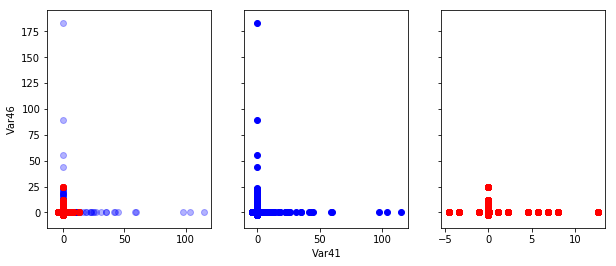

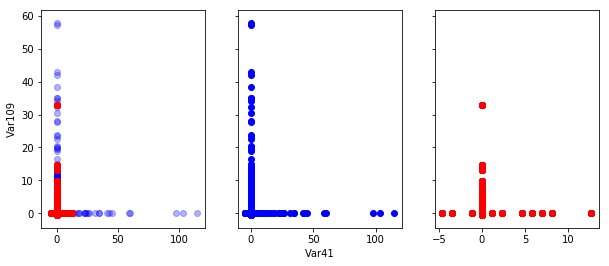

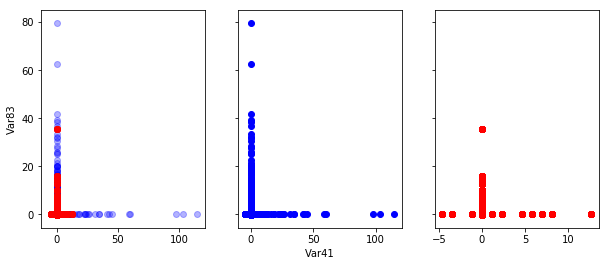

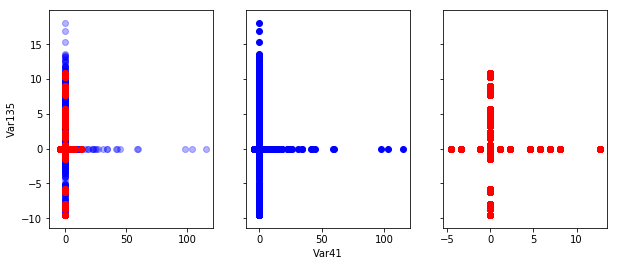

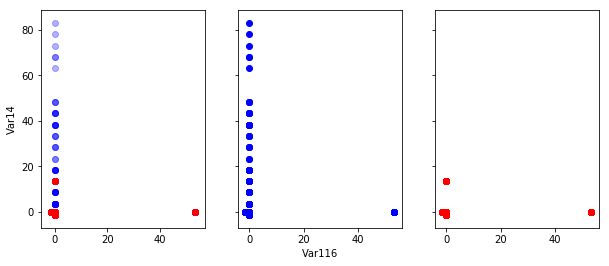

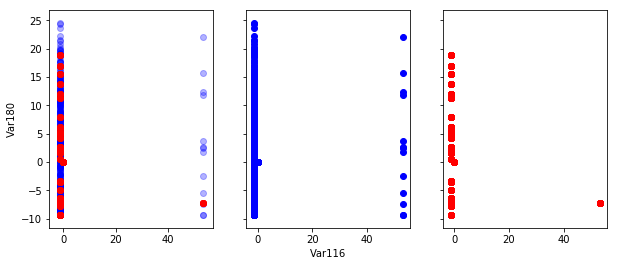

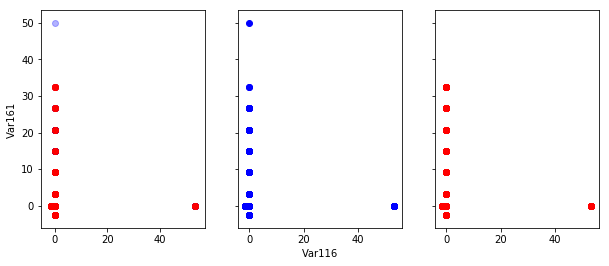

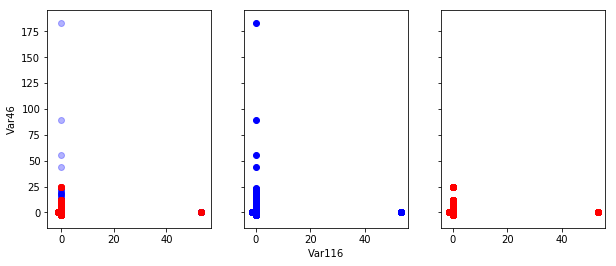

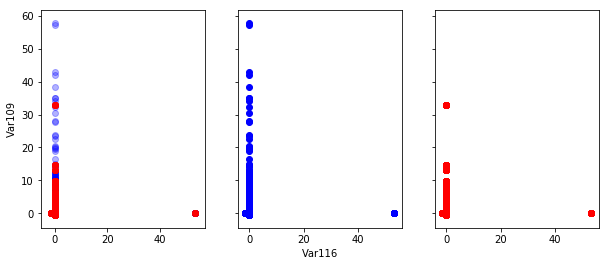

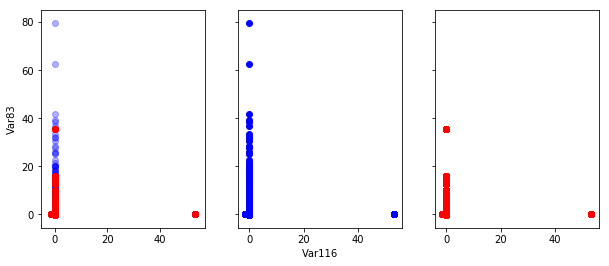

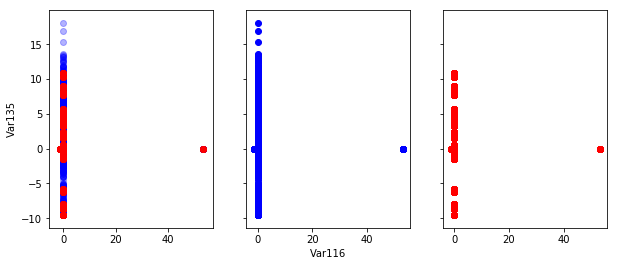

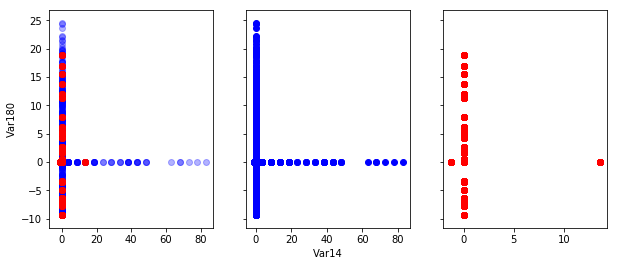

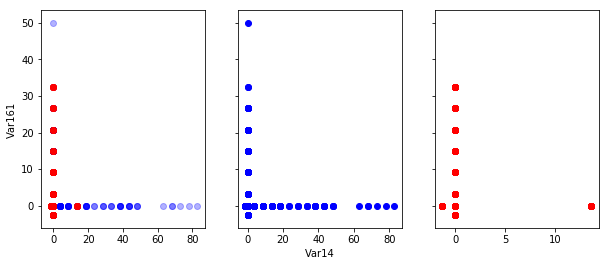

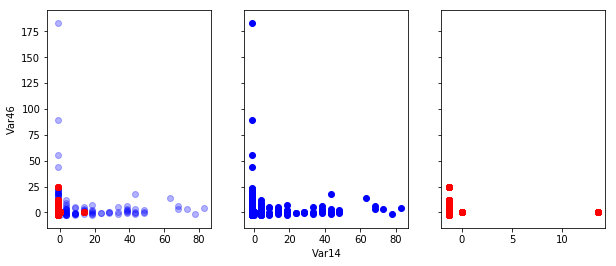

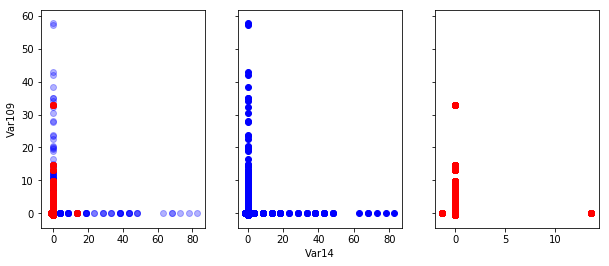

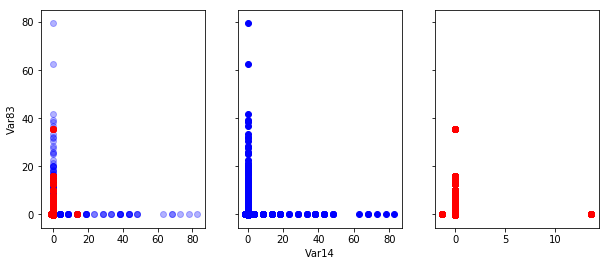

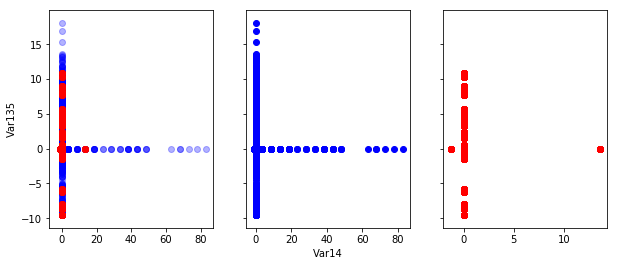

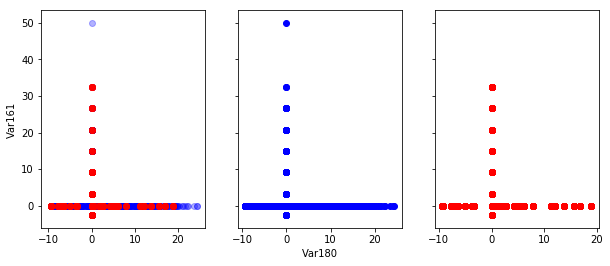

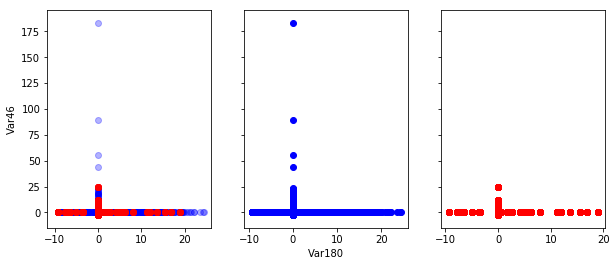

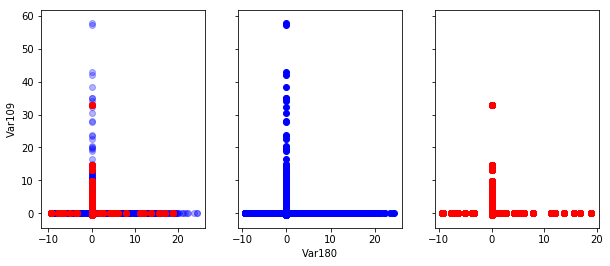

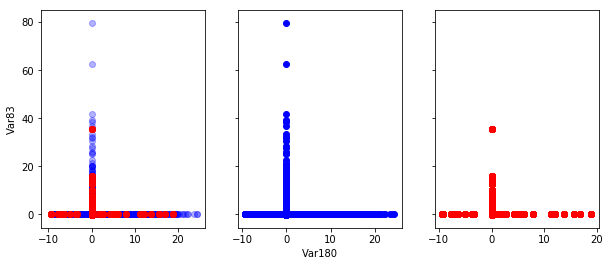

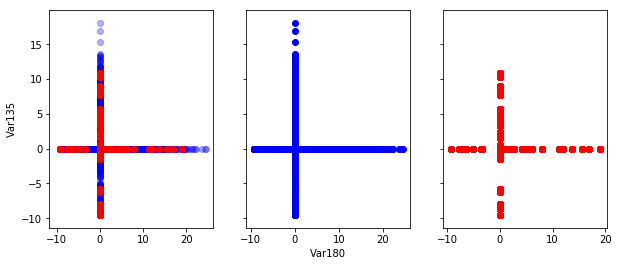

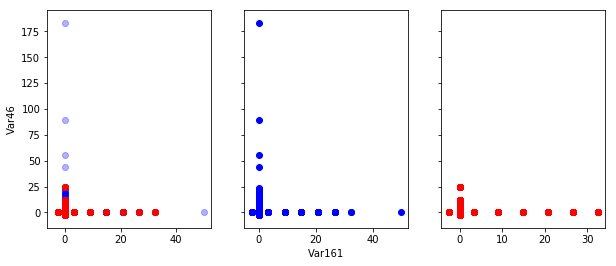

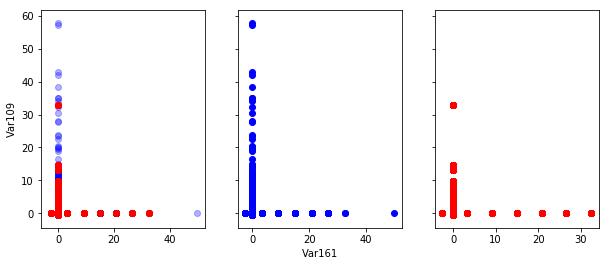

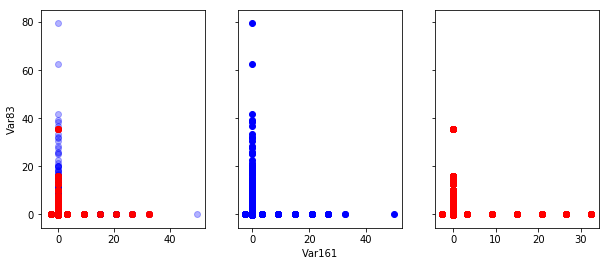

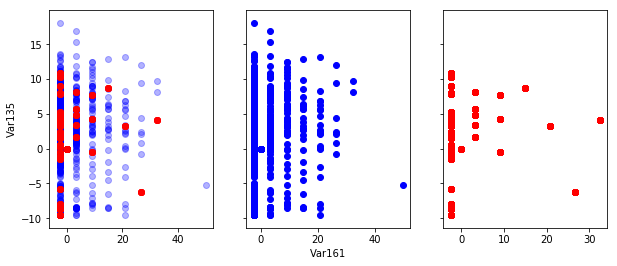

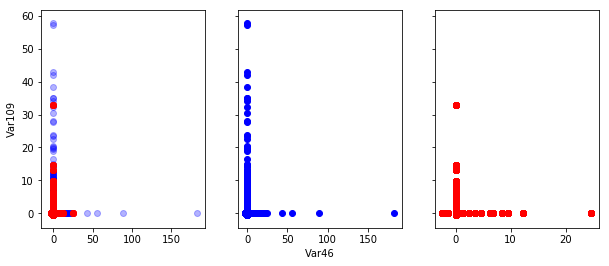

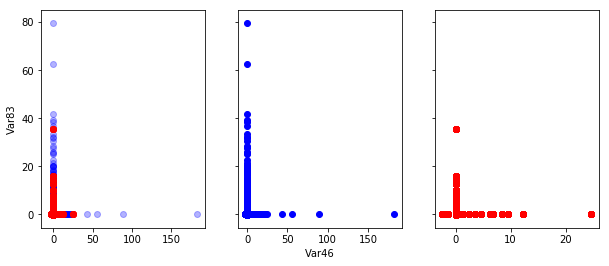

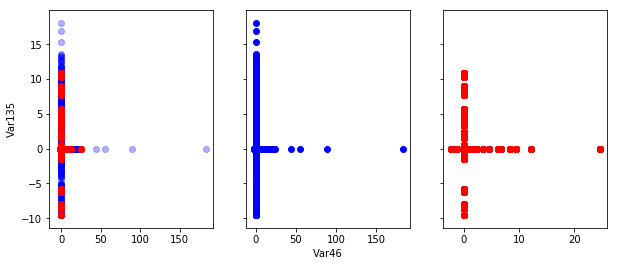

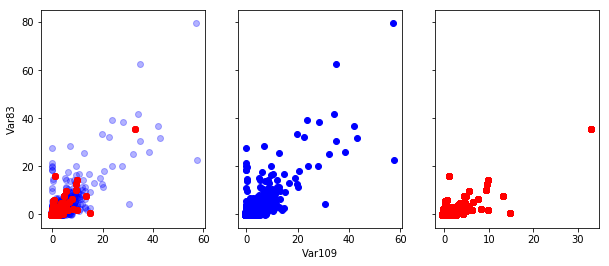

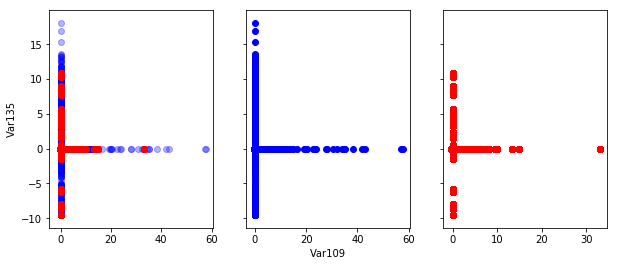

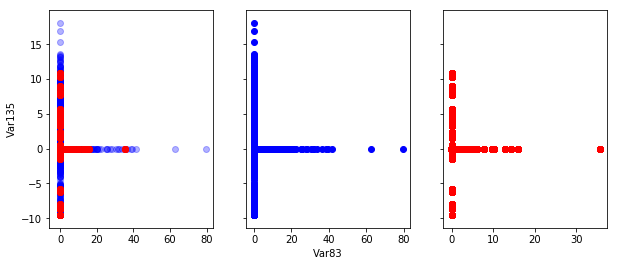

In [19]:
# И диаграммы рассеяния
build_scatter_plots(
    numeric_balanced_frame,
    random_columns,
    class_descriptions)

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

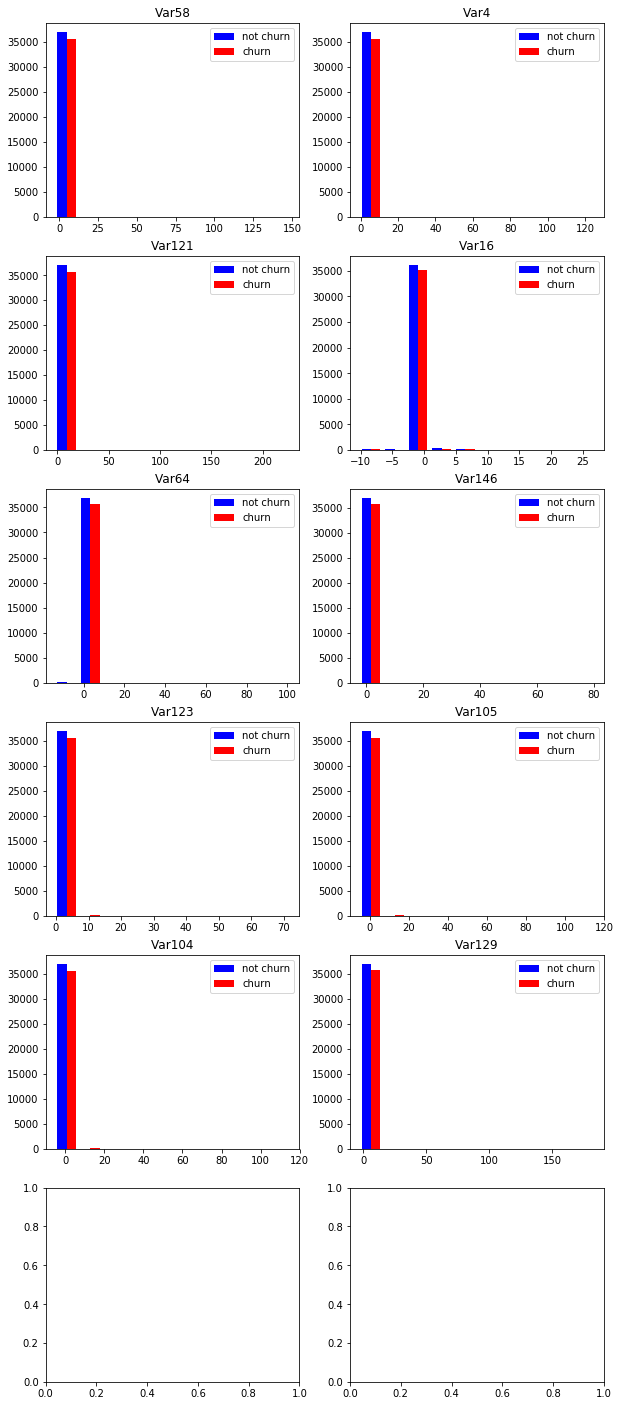

In [20]:
build_distribution_plots(numeric_balanced_frame, bottom_columns, class_descriptions)

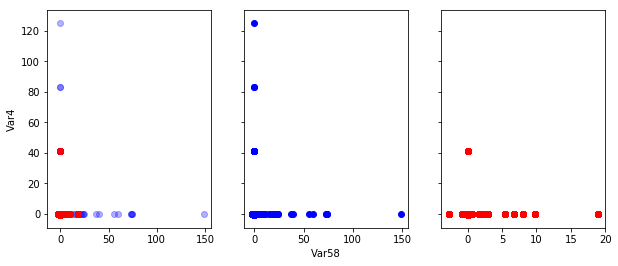

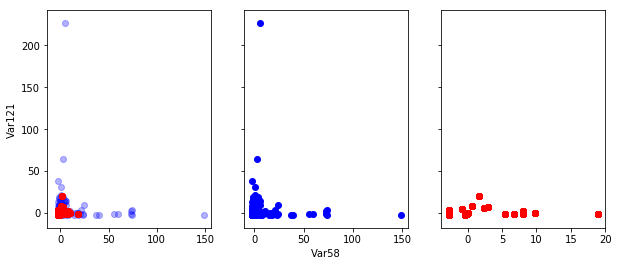

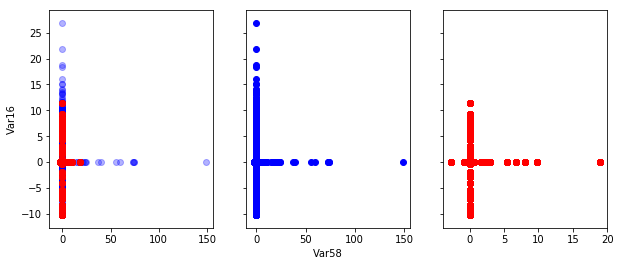

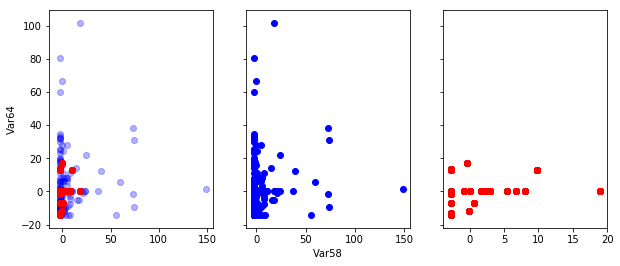

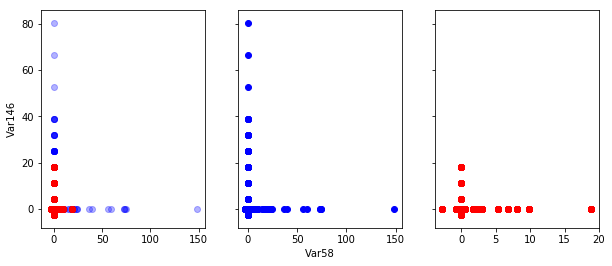

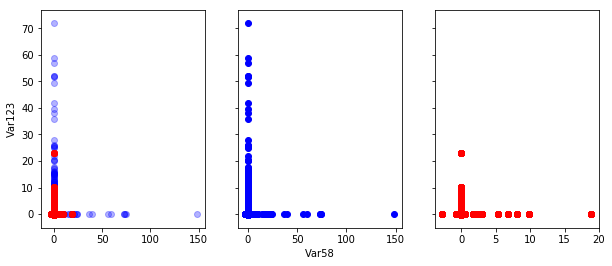

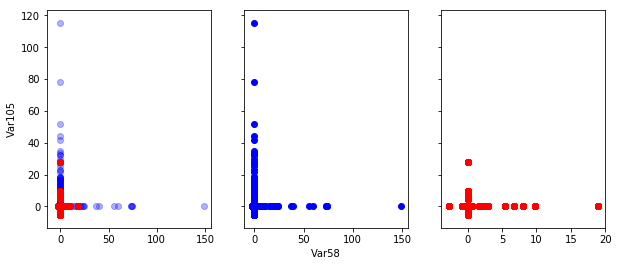

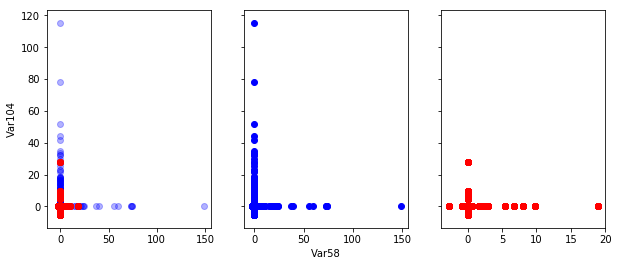

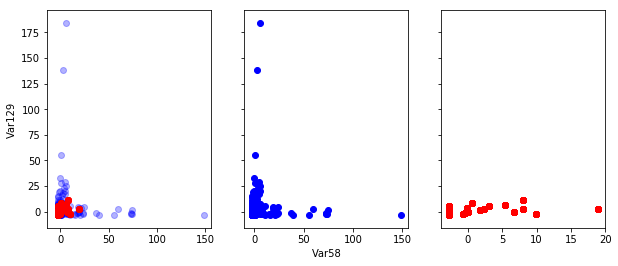

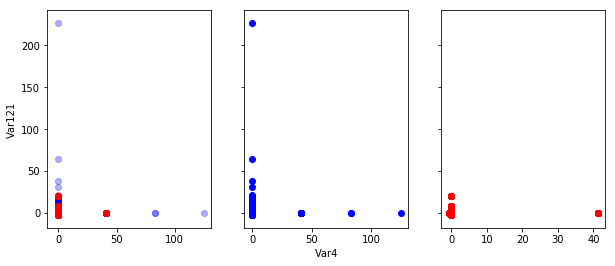

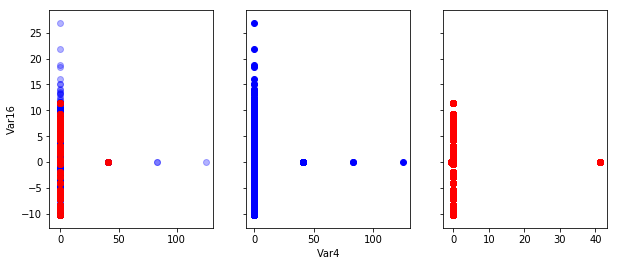

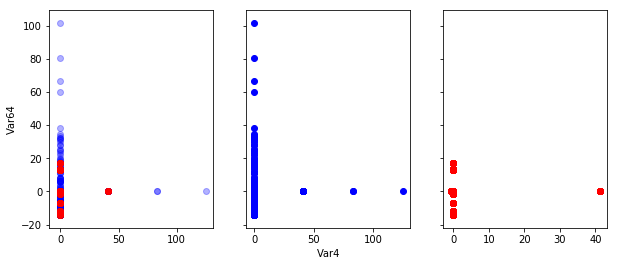

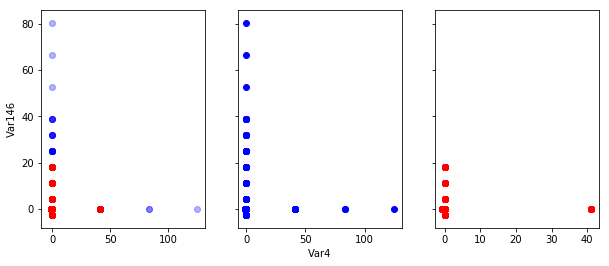

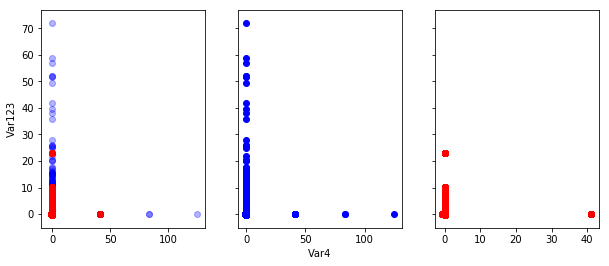

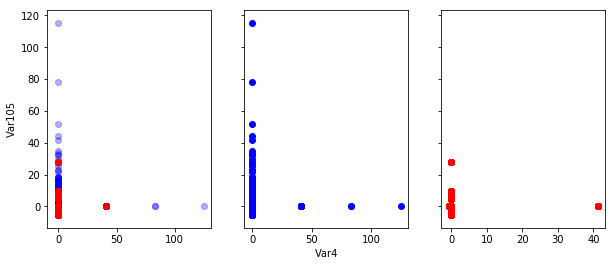

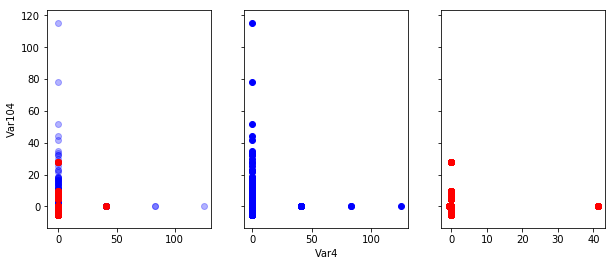

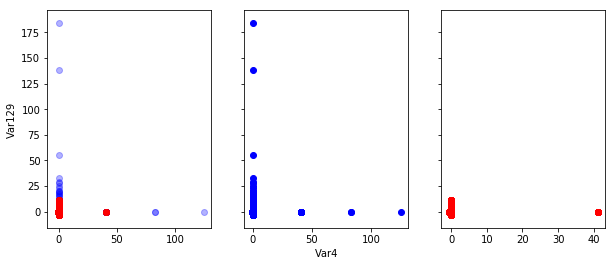

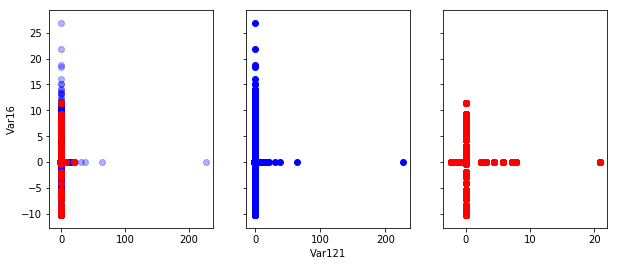

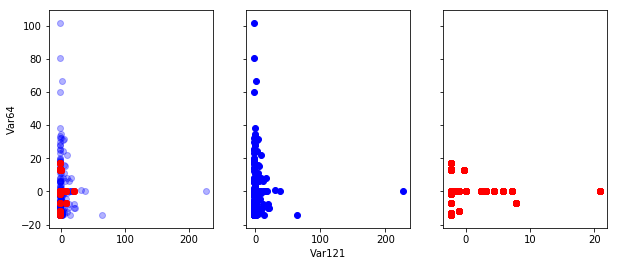

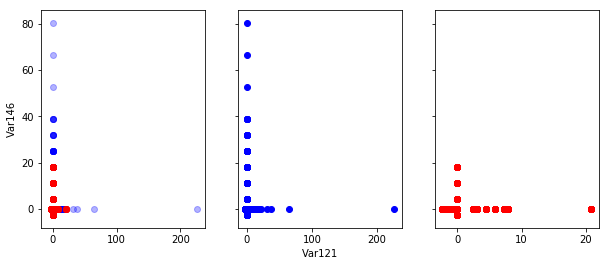

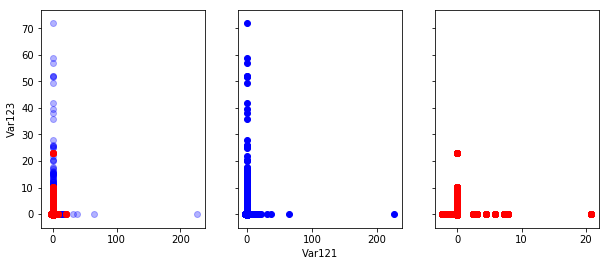

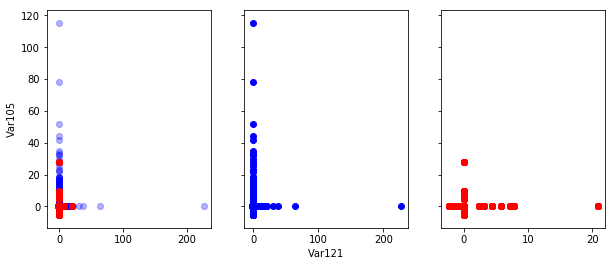

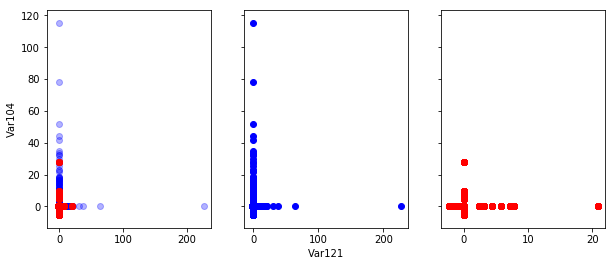

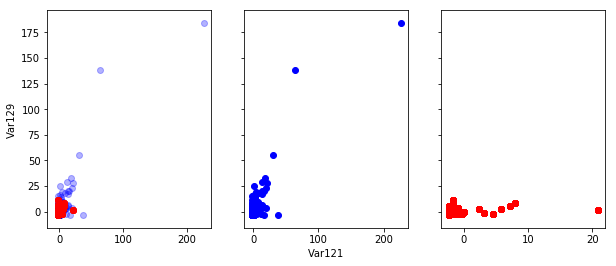

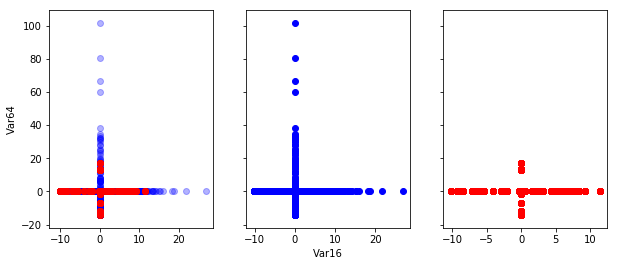

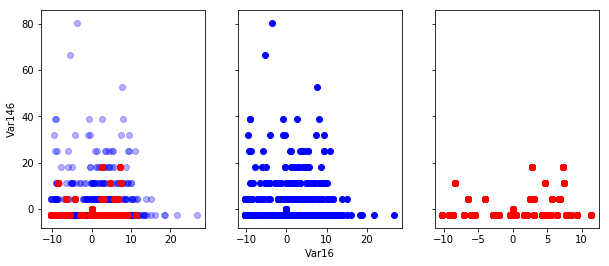

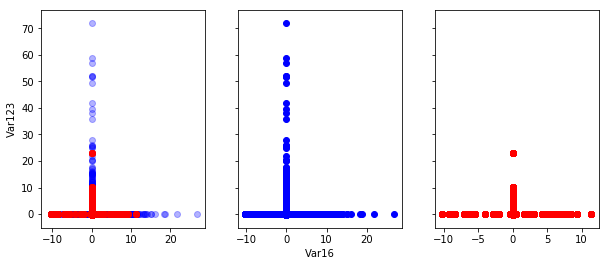

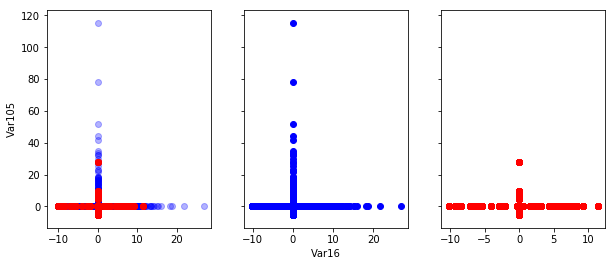

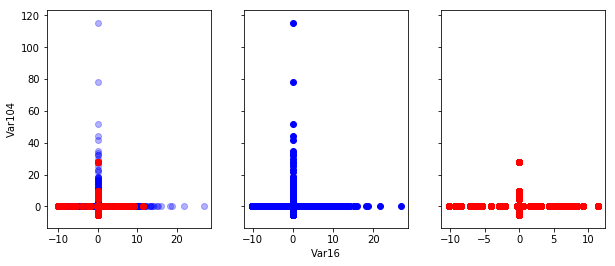

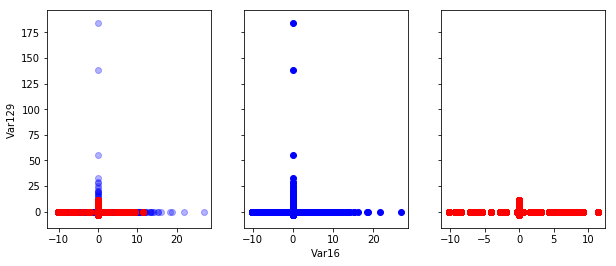

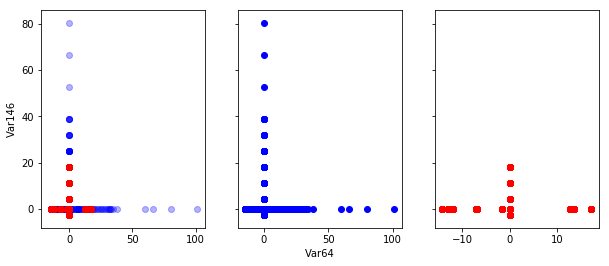

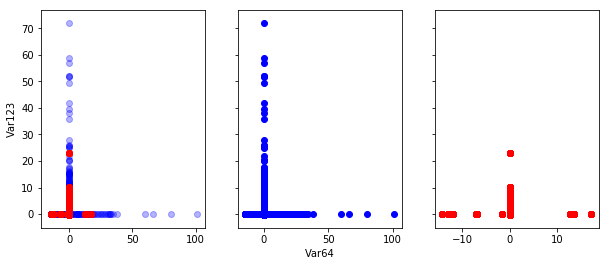

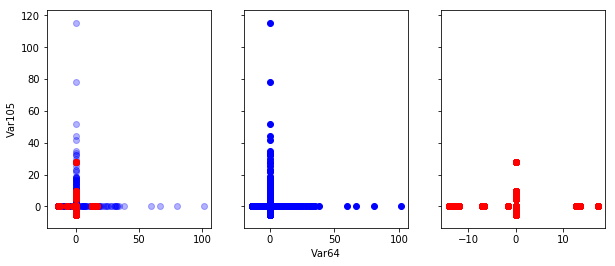

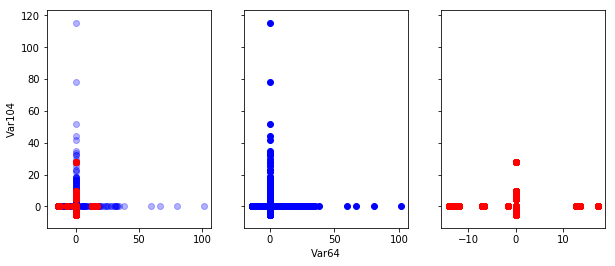

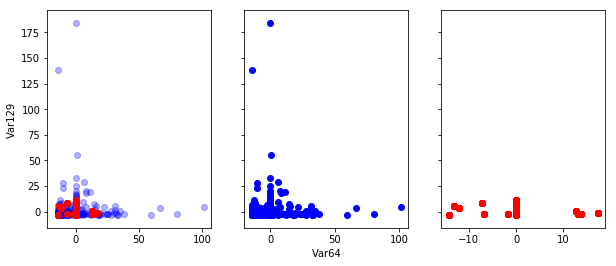

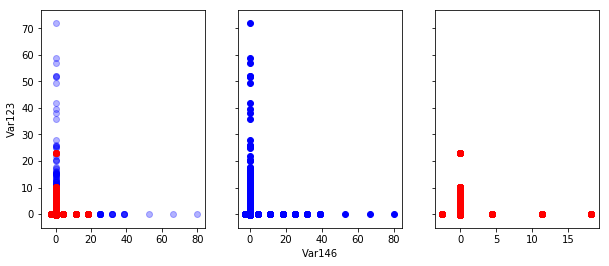

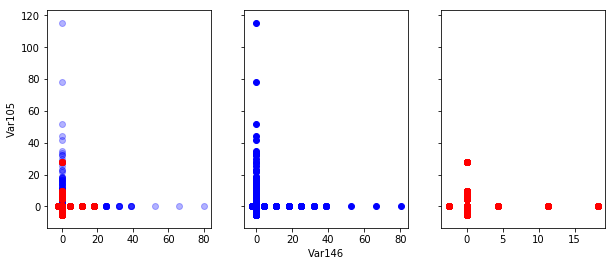

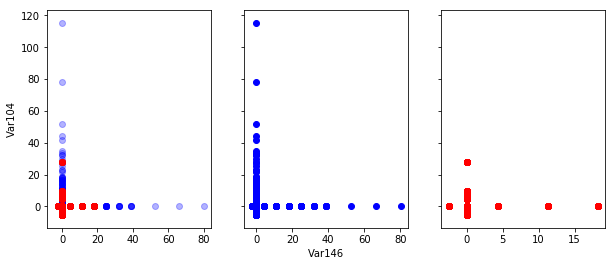

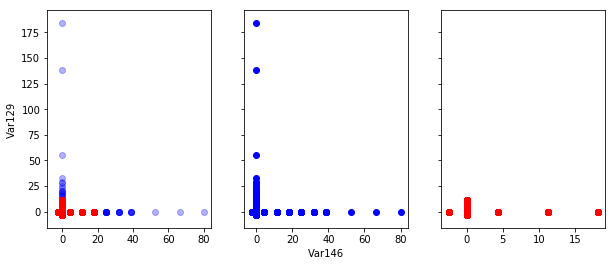

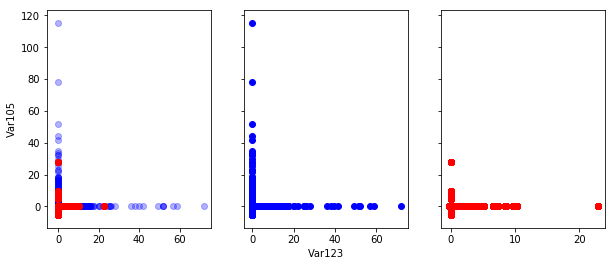

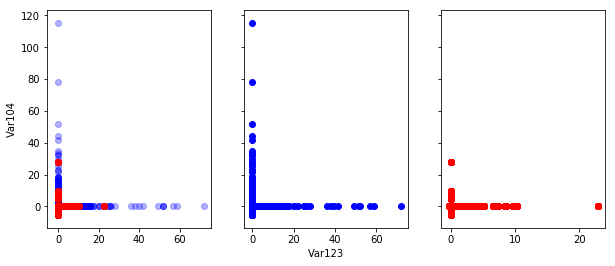

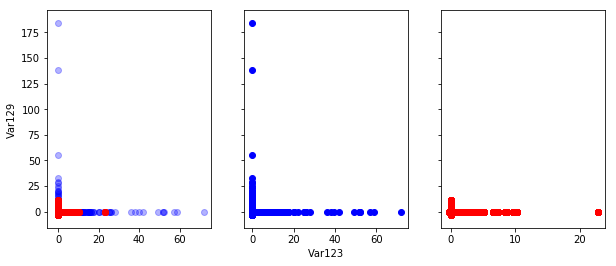

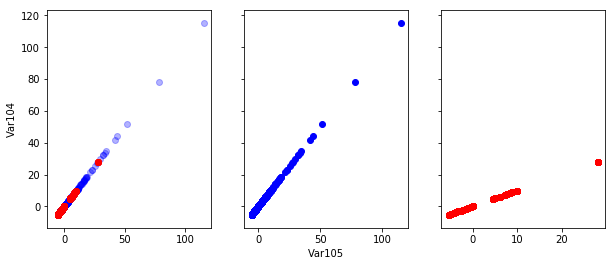

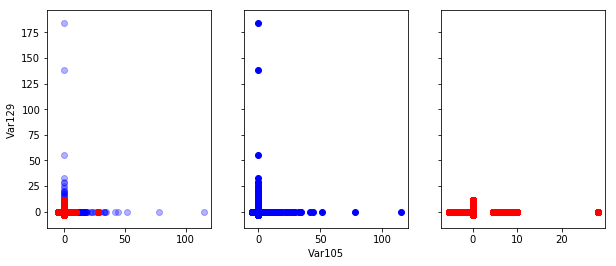

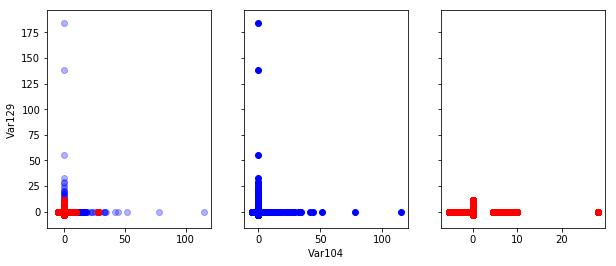

In [21]:
build_scatter_plots(
    numeric_balanced_frame,
    bottom_columns,
    class_descriptions)

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

In [84]:
def build_histograms(frame, features, class_descriptions):
    """ Функция строит гистограммы распределений выбранных категориальных колонок датасета по классам """
    fig, axes = plt.subplots(
        nrows=int(len(features)/2)+1,
        ncols=2,
        figsize=(10, 25))
    for feature_idx, col in enumerate(features):
        data = []
        colors = []
        labels = []
        for cl_idx, indices, data_class, color in class_descriptions:
            counts = frame.loc[indices,[col]].apply(pd.value_counts)
            hist_data = []
            for idx, name in enumerate(counts.index):
                hist_data = hist_data + list(np.repeat(idx, counts.loc[name, col]))
            data.append(hist_data)
            colors.append(color)
            labels.append(data_class)
        ax = axes[int(feature_idx/2)][feature_idx%2]
        ax.hist(
            data,
            histtype='bar',
            color=colors,
            label=labels)
        ax.legend()
        ax.set_title(col)
    plt.show()

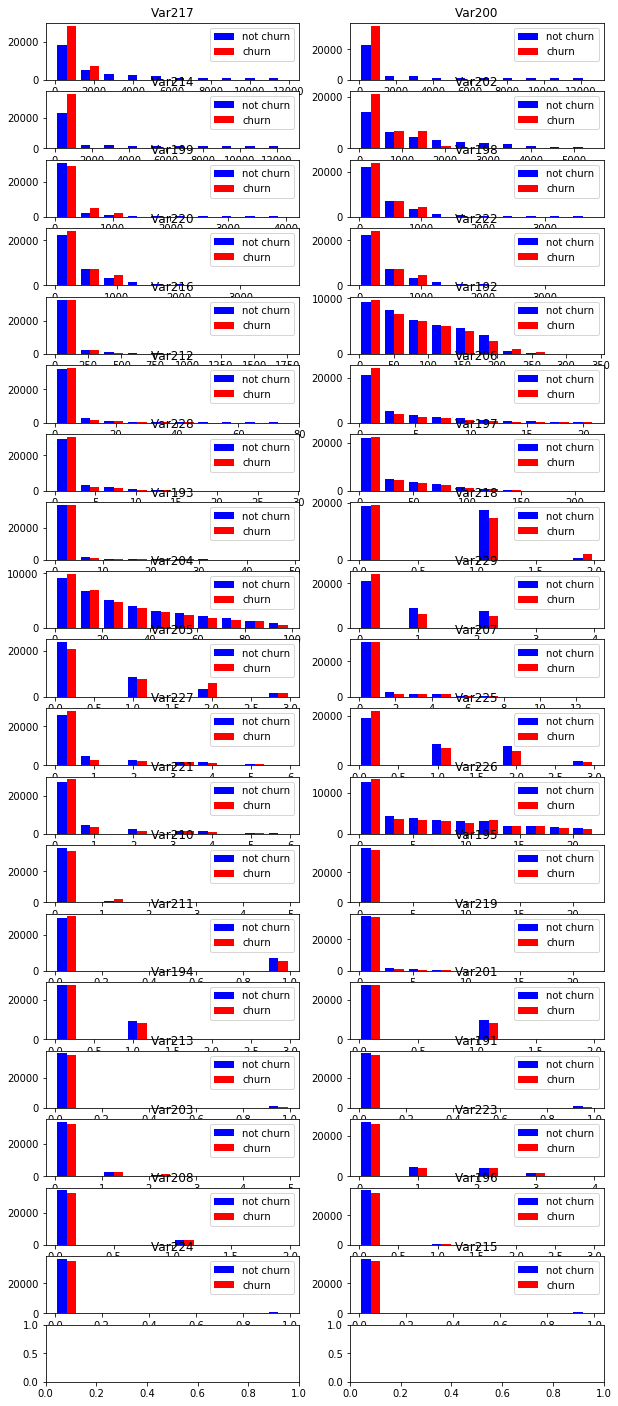

In [89]:
build_histograms(categorial_balanced_frame, categorial_features, class_descriptions)

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?

* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

## Заключение

Для большинства признаков распределение значений в классе churn такое-же как и в классе not churn. Гистограммы показывают, что распределения практически одинаковы и количественные соотношения значений пропорциональны соотношению классов.

Однако для некоторых признаков (например числовые Var73, Var126, Var144, Var7 и категориальные Var200, Var202, Var214, Var217) это не совсем так и некоторых значений для класса churn несколько больше, чем для класса not churn, не смотря на то, что примеров класса churn меньше. Для признаков справедливо утверждение, что признаки с перекосом значений в сторону класса churn находятся в списке признаков с наибольшей корреляцией.
Как мне кажется эти признаки и должны внести наибольший вклад в модель.

Наименее полезными будут признаки распределение в которых абсолютно идентично для классов churn и not churn.
Среди таких признаков в частности оказались те, что дали минимальную меру взаимосвязи.

При первом взгляде на scatter plot можно увидеть, что во многих случаях признаки класса churn принимают меньше значений, чем те же самые признаки класса not churn. Если вдуматься, то это логично, т.к. объектов класса churn значительно меньше.

При просмотре графиков рассяения можно обратить внимание на то, что многие графики очень похожи друг на друга. Из этого можно предположить, что в данных имеются скореллированные признаки. Я проверил это посчитав корреляции для числовых признаков (смотри ниже) и действительно в данных есть достаточно много сильно скореллированных признаков. Это и то, что есть признаки, которые могут внести неплохой вклад в модель означает, что отбор признаков окажется полезным для построения модели.

In [24]:
correlations = numeric_balanced_frame.corr(method="spearman")
top_correlations = []
for col1_idx, col1 in enumerate(numeric_balanced_frame.columns):
    for col2_idx, col2 in enumerate(numeric_balanced_frame.columns[(col1_idx+1):]):
        correlation = abs(correlations.loc[col1, col2])
        if correlation > 0.8:
            top_correlations.append((col1, col2, correlation))
top_correlations = sorted(top_correlations, key=lambda v: abs(v[2]), reverse=True)
top_correlations

[('Var66', 'Var156', 1.0),
 ('Var71', 'Var91', 1.0),
 ('Var88', 'Var128', 1.0),
 ('Var104', 'Var105', 1.0),
 ('Var9', 'Var66', 0.99631621088720135),
 ('Var9', 'Var156', 0.99631621088720135),
 ('Var29', 'Var90', 0.98533968414748263),
 ('Var2', 'Var49', 0.98078051383069709),
 ('Var27', 'Var67', 0.97978360988164837),
 ('Var2', 'Var122', 0.97803488203277378),
 ('Var21', 'Var22', 0.97124101503909588),
 ('Var4', 'Var138', 0.9691438783394426),
 ('Var49', 'Var122', 0.96156107505282362),
 ('Var26', 'Var67', 0.95844423397226675),
 ('Var26', 'Var27', 0.95395160636426535),
 ('Var90', 'Var116', 0.94345321494571666),
 ('Var29', 'Var116', 0.93717023795735099),
 ('Var3', 'Var14', 0.92088005620129021),
 ('Var19', 'Var138', 0.9180727098403515),
 ('Var67', 'Var93', 0.91801236438270595),
 ('Var143', 'Var173', 0.91423863081179857),
 ('Var27', 'Var93', 0.91352048381731754),
 ('Var2', 'Var11', 0.91038734115965603),
 ('Var106', 'Var164', 0.90212723836514874),
 ('Var11', 'Var49', 0.8994031692575436),
 ('Var44'

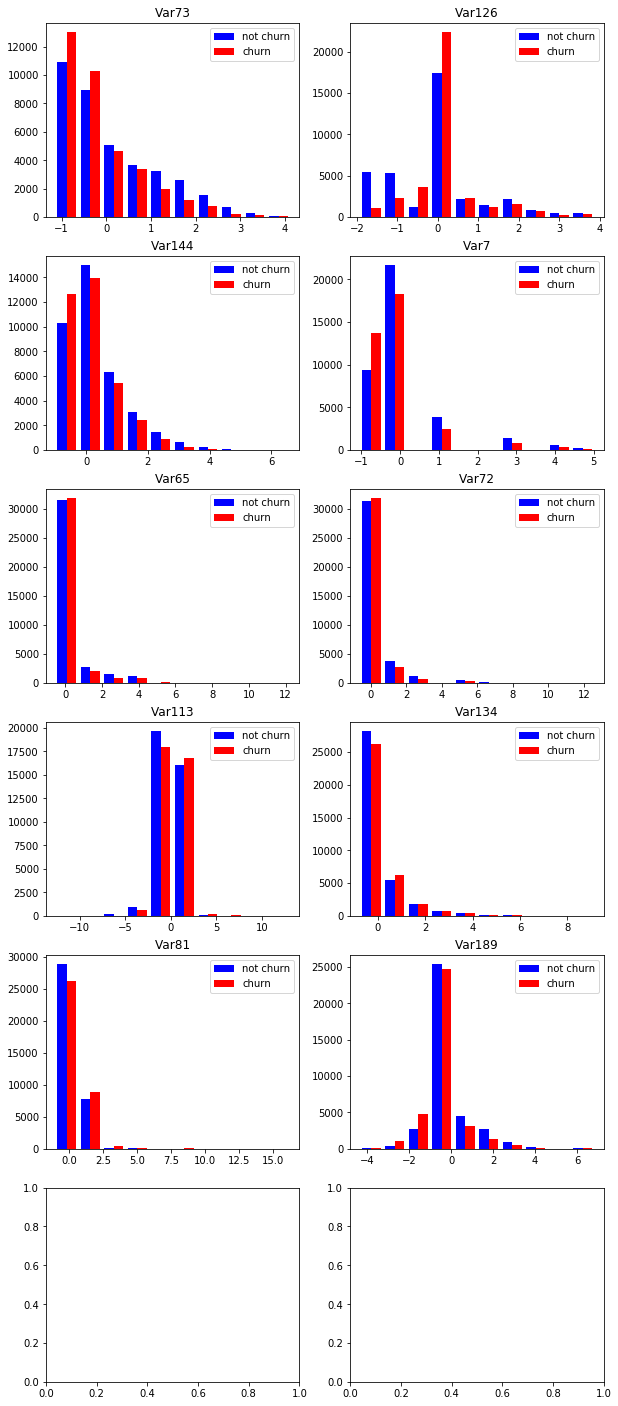

In [25]:
possibly_good_features = ["Var73", "Var126", "Var144", "Var7", "Var65", "Var72", "Var113", "Var134", "Var81", "Var189"]
build_distribution_plots(numeric_balanced_frame, possibly_good_features, class_descriptions)

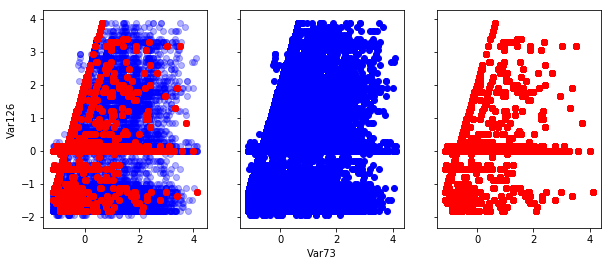

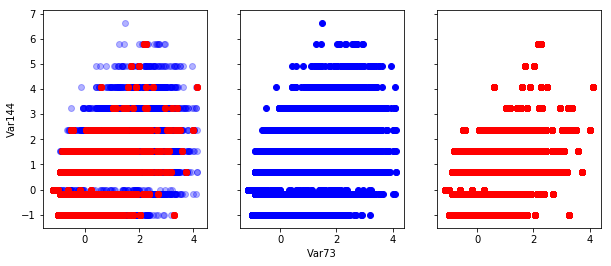

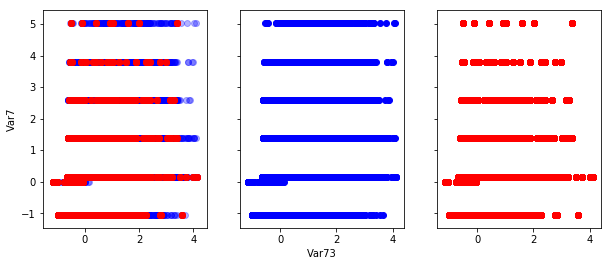

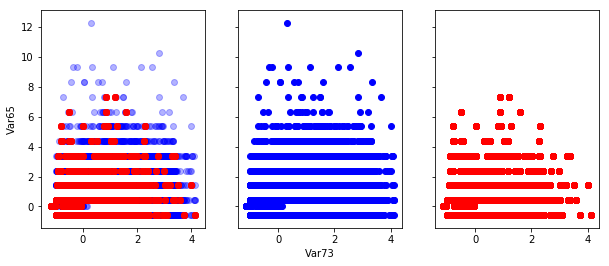

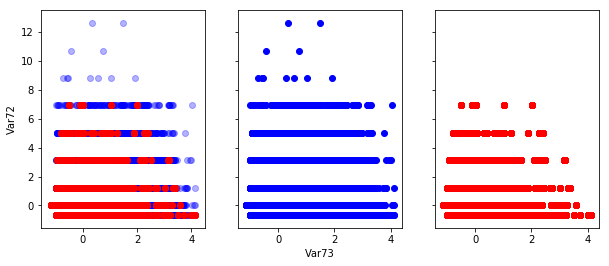

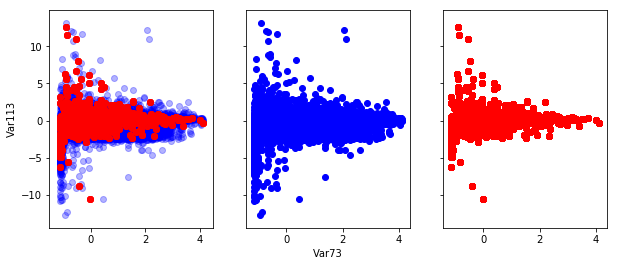

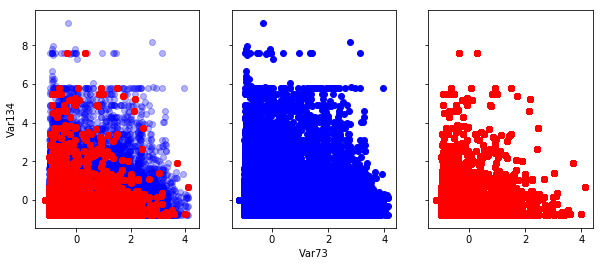

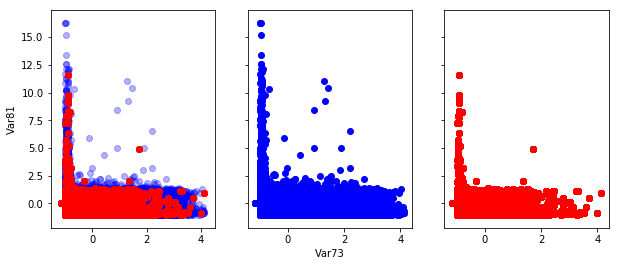

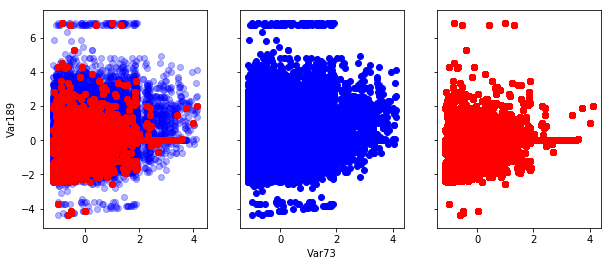

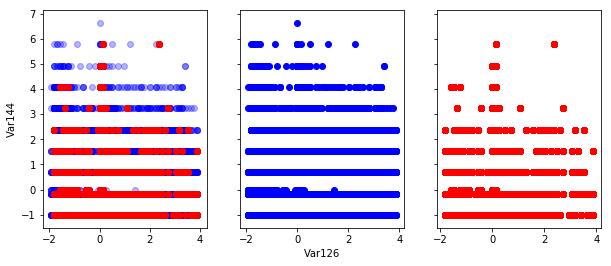

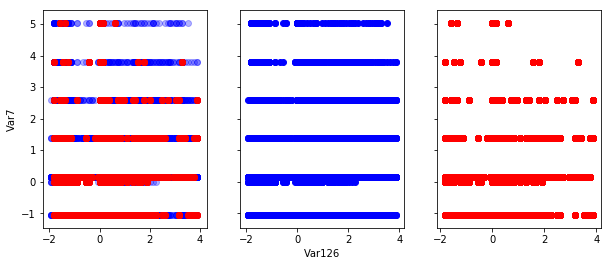

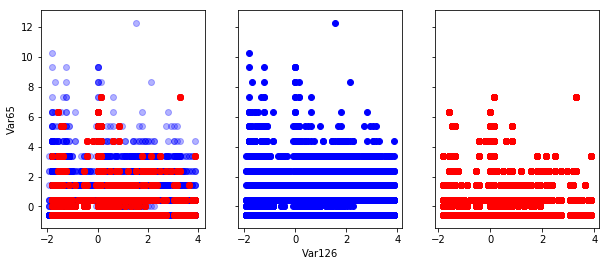

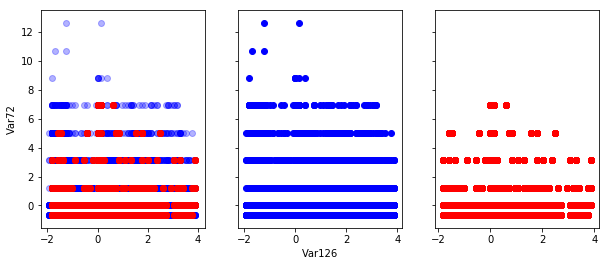

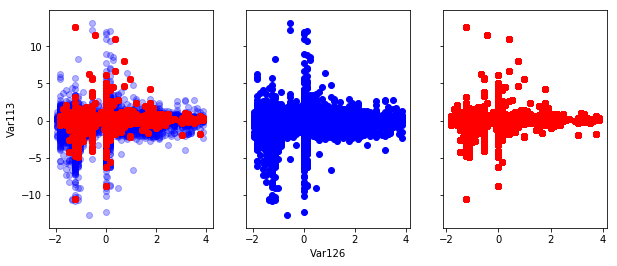

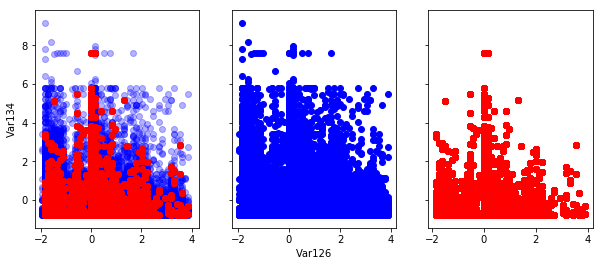

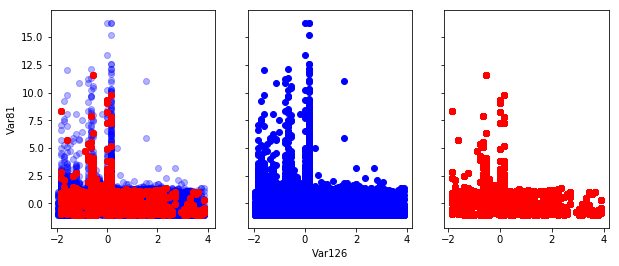

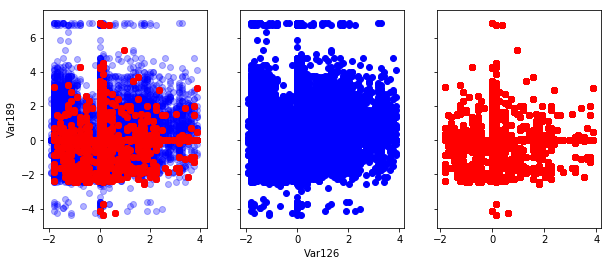

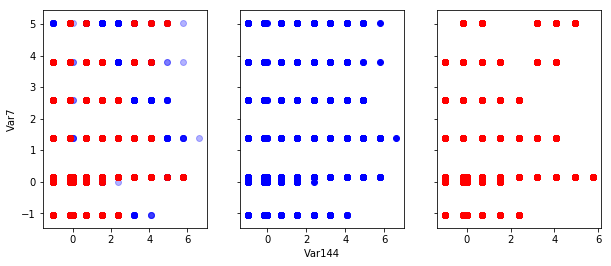

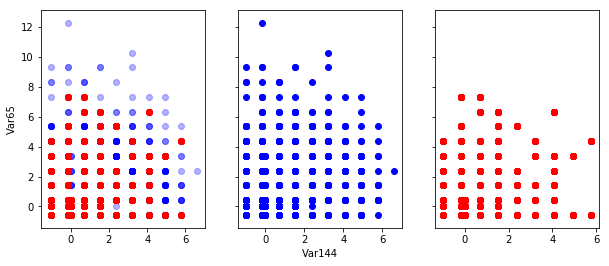

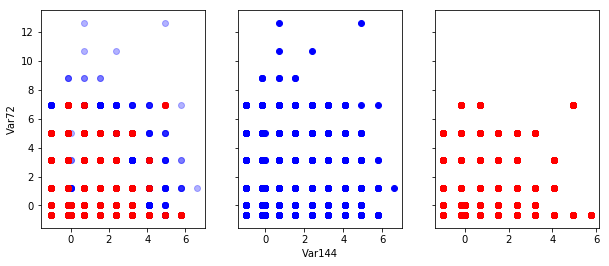

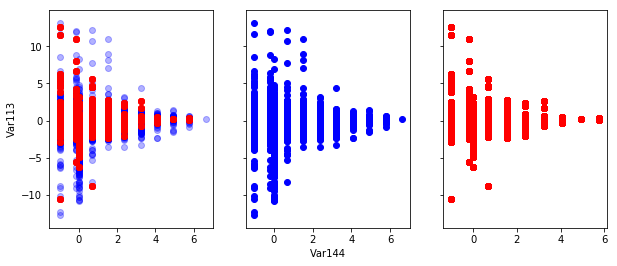

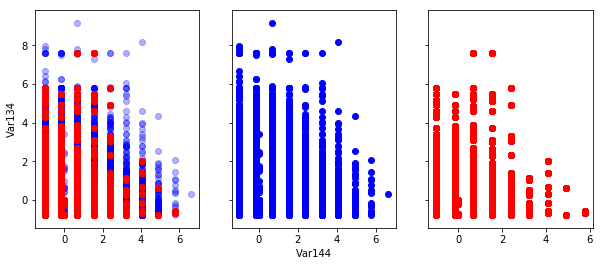

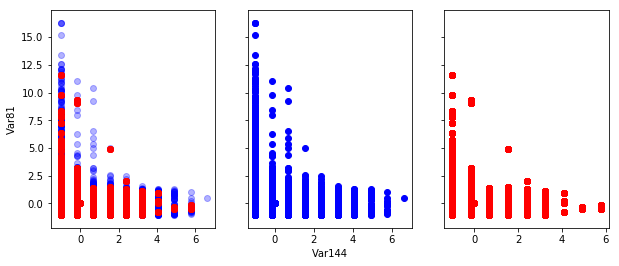

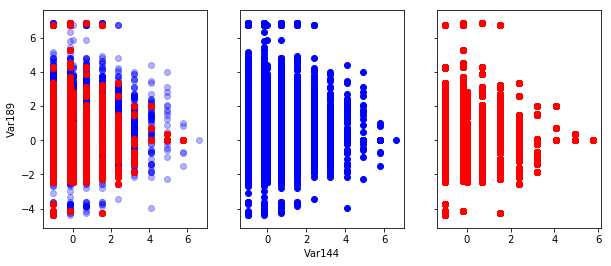

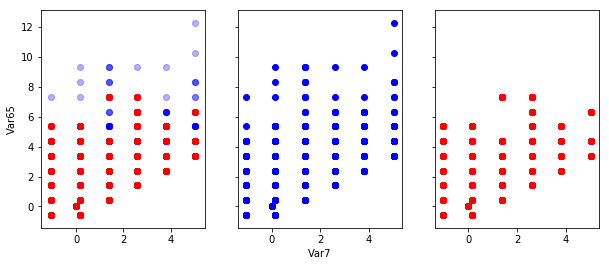

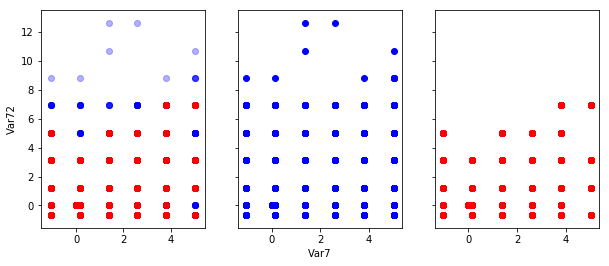

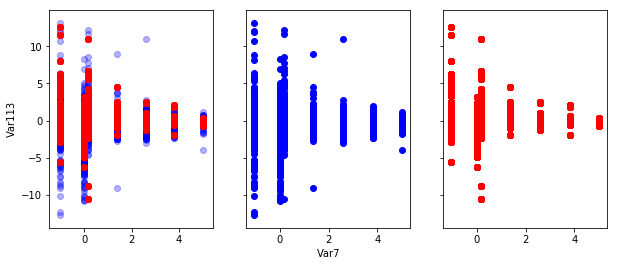

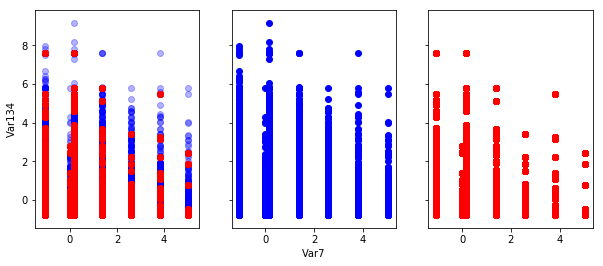

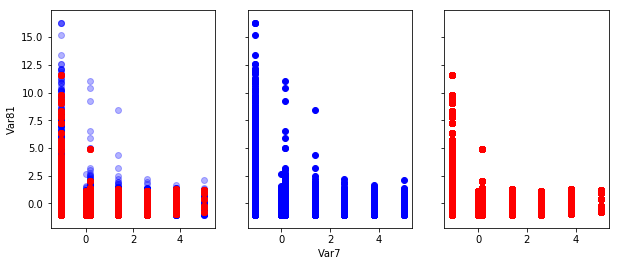

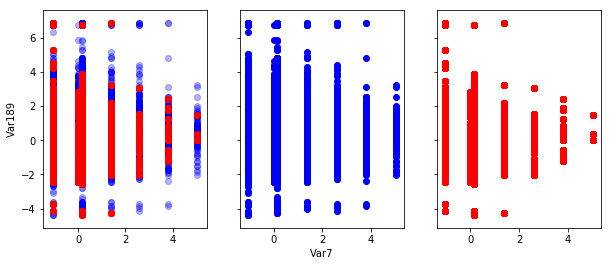

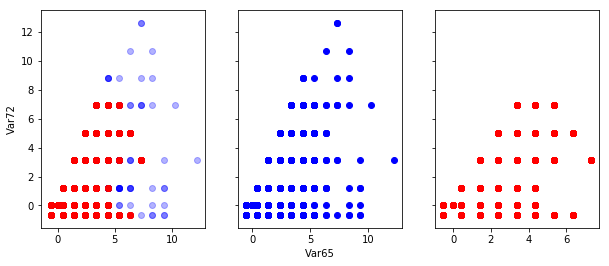

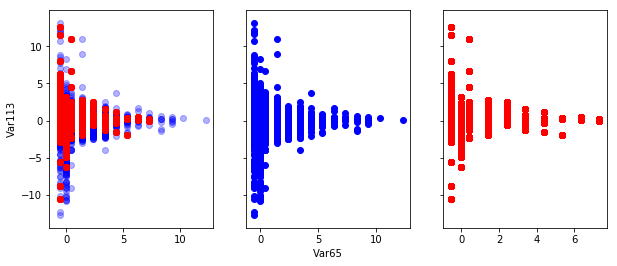

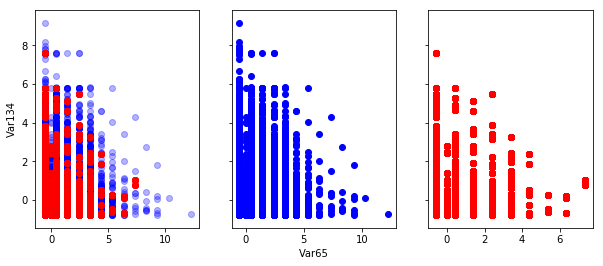

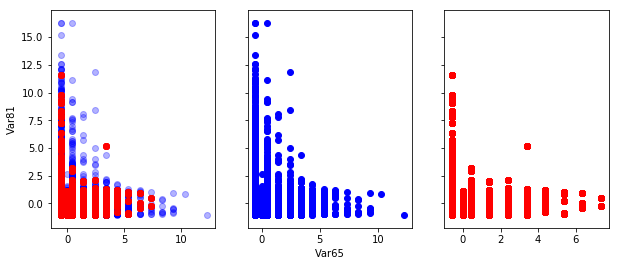

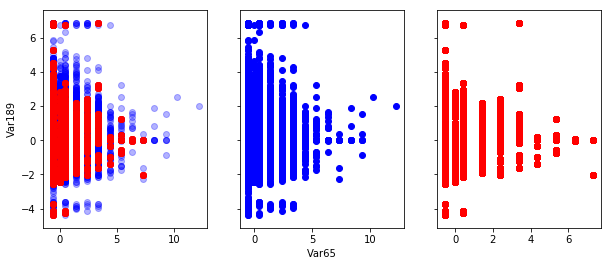

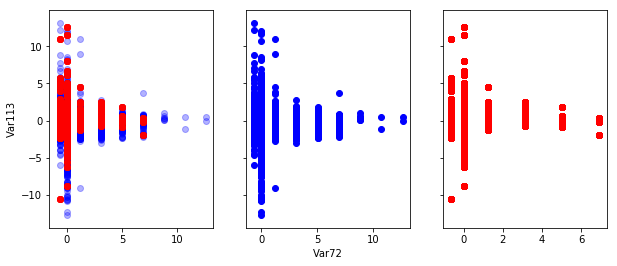

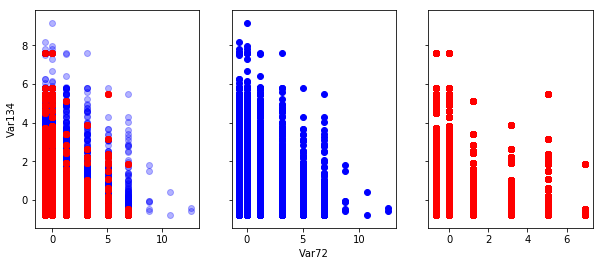

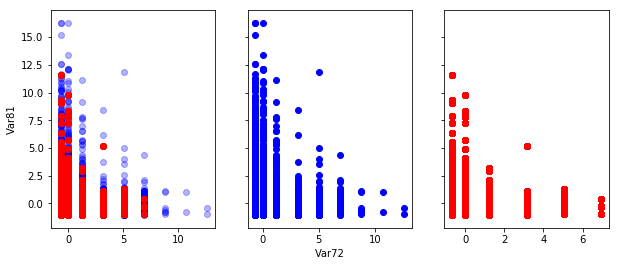

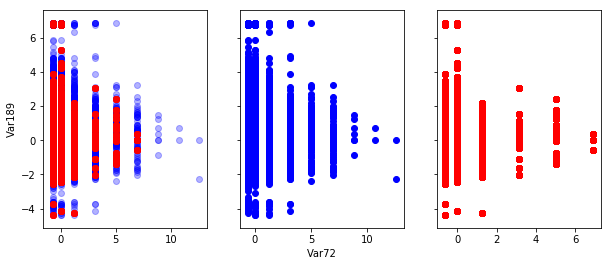

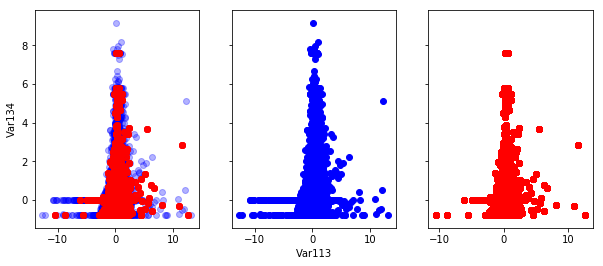

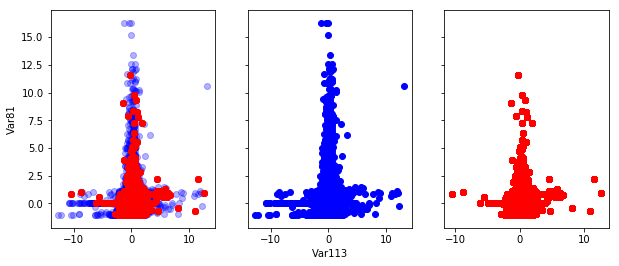

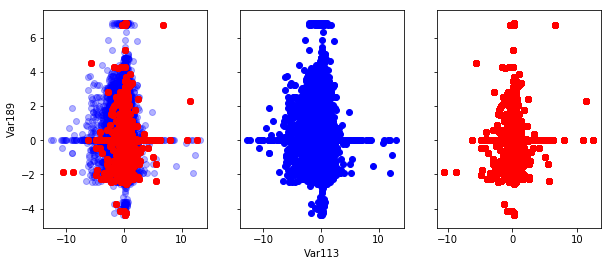

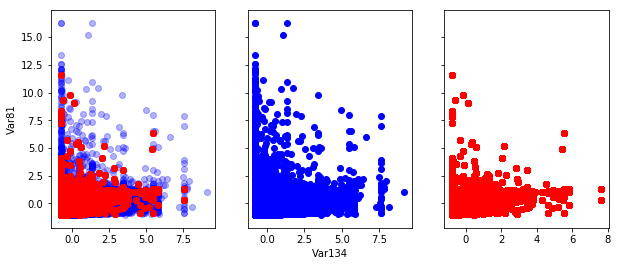

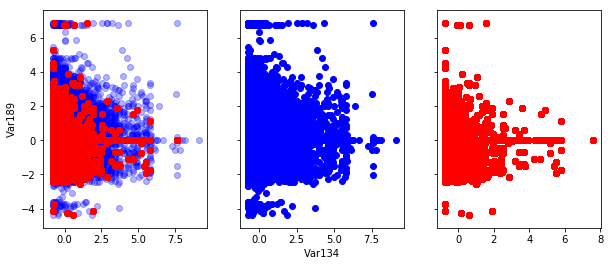

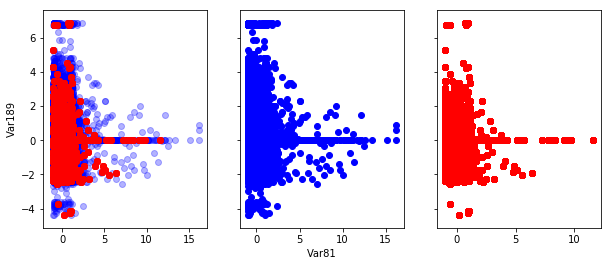

In [26]:
build_scatter_plots(
    numeric_balanced_frame,
    possibly_good_features,
    class_descriptions)

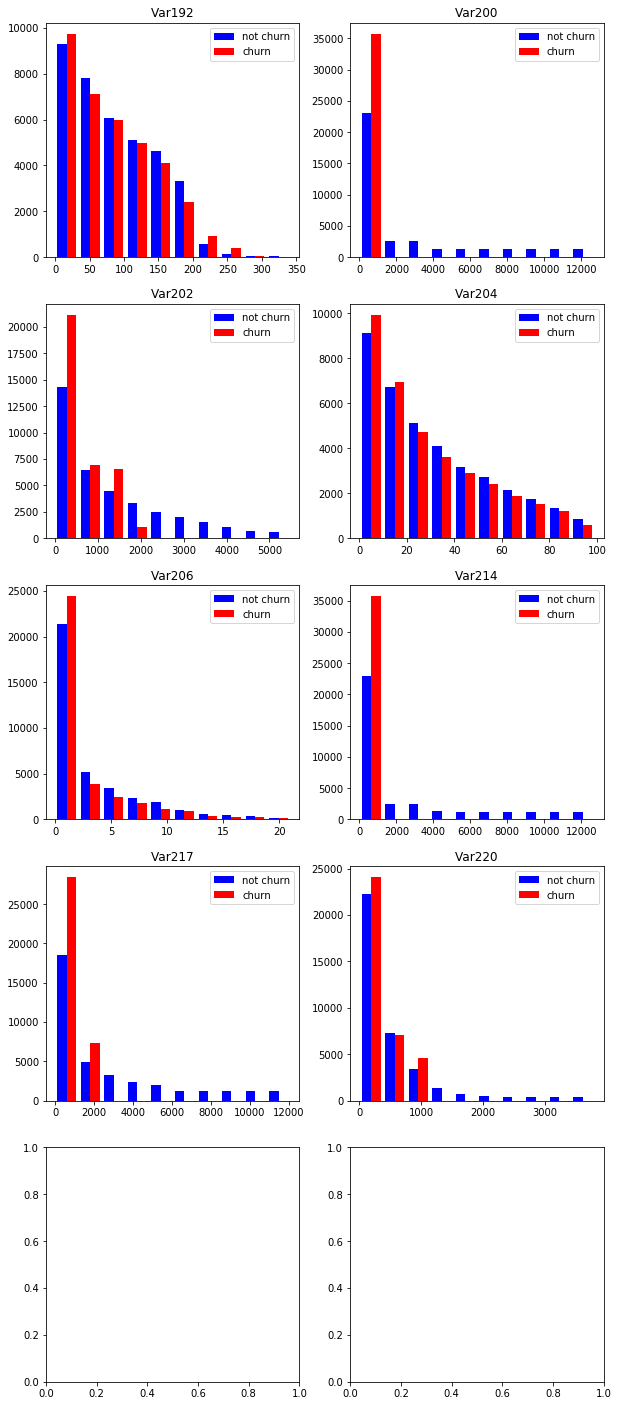

In [90]:
possibly_good_categorial_features = ["Var192", "Var200", "Var202", "Var204", "Var206", "Var214", "Var217", "Var220"]
build_histograms(categorial_balanced_frame, possibly_good_categorial_features, class_descriptions)

In [37]:
correlations = []
for feature_idx1, feature1 in enumerate(categorial_balanced_frame.columns):
    for feature_idx2, feature2 in enumerate(categorial_balanced_frame.columns[feature_idx1+1:]):
        pivot = build_pivot_table(categorial_balanced_frame, categorial_balanced_frame[feature2], feature1)
        correlations.append((feature1, feature2, v_Cramer_correlation(pivot)))
top_cat_correlations = sorted(correlations, key=lambda v: v[2], reverse=True)
top_cat_correlations

In [110]:
top_categorial_corrs = [(f1,f2,np.round(corr, 2)) for f1,f2,corr in top_cat_correlations if corr > 0.99]
first_features, second_features, corrs = zip(*top_categorial_corrs)
very_correlated_features = []
features_to_remove = []
for very_correlated in list(set(first_features + second_features)):
    correlated_with = []
    for f1,f2,corr in top_categorial_corrs:
        correlated_feature = f2 if f1 == very_correlated else (f1 if f2 == very_correlated else None)
        if (not correlated_feature is None) and correlated_feature not in features_to_remove:
            correlated_with.append((correlated_feature, corr))
    correlations_count = len(correlated_with)
    if correlations_count > 0:
        features_to_remove.append(very_correlated)
    very_correlated_features.append((very_correlated, correlations_count, correlated_with))
very_correlated_features = sorted(very_correlated_features, key=lambda d: d[1], reverse=True)
correlated_labeled_features = []
for f,c,l in very_correlated_features:
    label = f
    if c > 0:
        corrs_list = [cf+"(" + str(cr) + ")" for cf,cr in l]
        label = f + "[" + str(c) + "] correlates with" + ", ".join(corrs_list)
    correlated_labeled_features.append((f, label))
correlated_labeled_features

[('Var222',
  'Var222[4] correlates withVar198(1.0), Var220(1.0), Var207(1.0), Var227(1.0)'),
 ('Var214',
  'Var214[4] correlates withVar200(1.0), Var225(1.0), Var201(1.0), Var194(1.0)'),
 ('Var202', 'Var202[2] correlates withVar226(1.0), Var204(1.0)'),
 ('Var207', 'Var207[2] correlates withVar198(1.0), Var220(1.0)'),
 ('Var220', 'Var220[2] correlates withVar198(1.0), Var227(1.0)'),
 ('Var200', 'Var200[2] correlates withVar225(1.0), Var201(1.0)'),
 ('Var218', 'Var218[1] correlates withVar217(1.0)'),
 ('Var194', 'Var194[1] correlates withVar200(1.0)'),
 ('Var198', 'Var198[1] correlates withVar227(1.0)'),
 ('Var221', 'Var221[1] correlates withVar216(1.0)'),
 ('Var212', 'Var212[1] correlates withVar216(1.0)'),
 ('Var226', 'Var226[1] correlates withVar204(1.0)'),
 ('Var217', 'Var217'),
 ('Var227', 'Var227'),
 ('Var201', 'Var201'),
 ('Var216', 'Var216'),
 ('Var225', 'Var225'),
 ('Var204', 'Var204')]

In [111]:
def build_histograms2(frame, features, class_descriptions, n_cols=2, fig_size=(10, 25)):
    """ Функция строит гистограммы распределений выбранных категориальных колонок датасета по классам """
    fig, axes = plt.subplots(
        nrows=int(len(features)/n_cols)+1,
        ncols=n_cols,
        figsize=(10, 25))
    for feature_idx, feature in enumerate(features):
        col, label = feature
        data = []
        colors = []
        labels = []
        for cl_idx, indices, data_class, color in class_descriptions:
            counts = frame.loc[indices,[col]].apply(pd.value_counts)
            hist_data = []
            for idx, name in enumerate(counts.index):
                hist_data = hist_data + list(np.repeat(idx, counts.loc[name, col]))
            data.append(hist_data)
            colors.append(color)
            labels.append(data_class)
        ax = axes[int(feature_idx/n_cols)][feature_idx%n_cols] if n_cols > 1 else axes[feature_idx]
        ax.hist(
            data,
            histtype='bar',
            color=colors,
            label=labels)
        ax.legend()
        ax.set_title(label)
    plt.show()

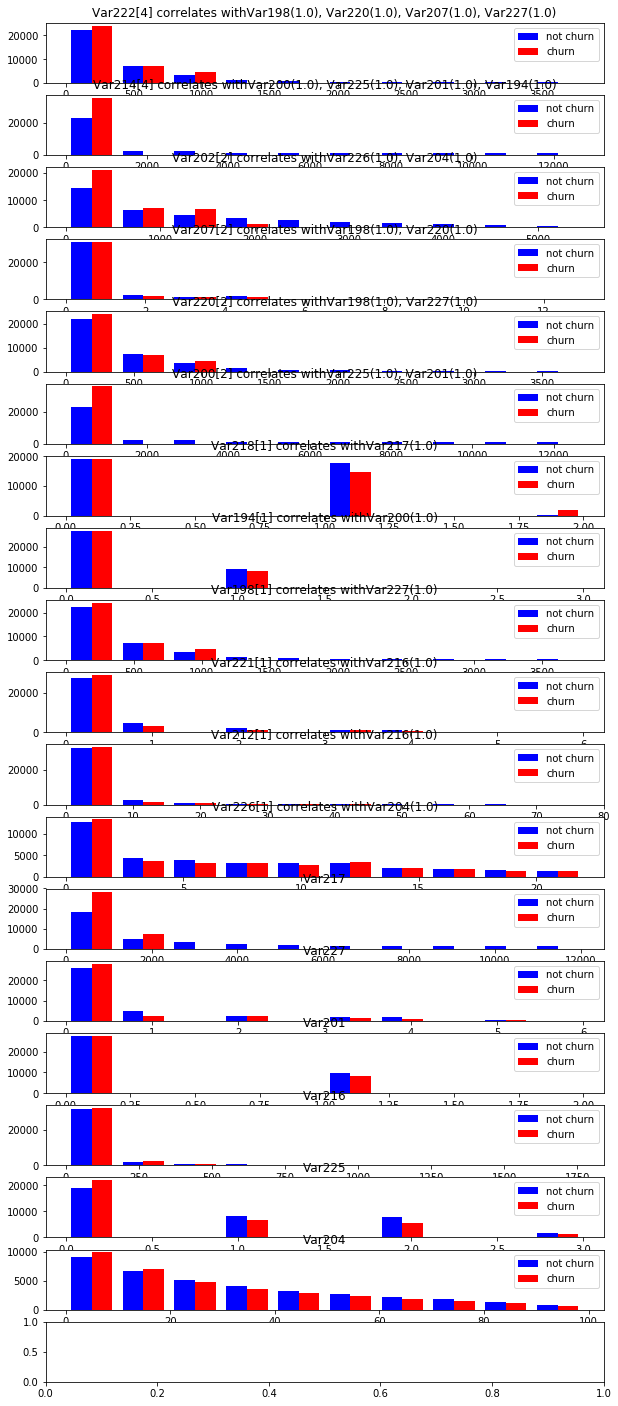

In [112]:
build_histograms2(
    categorial_balanced_frame,
    correlated_labeled_features,
    class_descriptions,
    n_cols=1,
    fig_size=(5,6*len(correlated_labeled_features)))

In [113]:
features_to_leave = [f for f,c,l in very_correlated_features if c == 0]
features_to_remove = []
for f,c,l in very_correlated_features:
    correlates_with_leave = False
    for cf, cr in l:
        if cf in features_to_leave:
            correlates_with_leave = True
            break
    if correlates_with_leave:
        features_to_remove.append(f)
features_to_remove

['Var222',
 'Var214',
 'Var202',
 'Var220',
 'Var200',
 'Var218',
 'Var198',
 'Var221',
 'Var212',
 'Var226']